In [1]:
data_path = '../../'
trial_info_file = '/A0_kabir/converted/trialinfo_matrix_A0_cleanedtrials.mat'
data_file = '/A0_kabir/Experimental/data.mat'
epoch_file = '/my_code/epochs_from_matrix/epochs_0.fif'

relevant_electrodes = ['O2','PO4','PO8','P8','P4','P6','P2','P1','P3','P5','P7','PO7','PO3','O1','Pz','POz','Oz','Iz']
electrodes_kabir = ['POz', 'PO3', 'PO4', 'Pz', 'P1', 'P3', 'Oz', 'O1', 'O2']

# Dic to index trial_info matrix
info_colnames = {'0':0 ,'1':1 ,'RT':2,'PTB_check_RT_error':3, 'answer':4,'stimuli_target_interval':5,\
                      'base_delay':6, 'flicker_sides':7, 'cued_side':8, 'orients_L':9, 'orients_r':10,\
                      'correct_resp':11, 'target_angle':12, 'tagging_type':13, 'trial_number':14}

In [2]:
import scipy.io as sio
import scipy
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.preprocessing import scale
from mne.decoding import ReceptiveField

In [3]:
# Load trial info
f = sio.loadmat(f'{data_path}{trial_info_file}')
trial_info = f['all_info']
# Create pd df to pass to mne metadata
pd_info = pd.DataFrame(trial_info, columns=info_colnames.keys())

In [4]:
# Load eeg epochs .fif and add metadata
epochs = mne.read_epochs(f'{data_path}{epoch_file}')
epochs.metadata = pd_info

Reading /home/gweindel/owncloud/projects/side/L/my_code/notebooks/../../my_code/epochs_from_matrix/epochs_0.fif ...
    Found the data of interest:
        t =   -1000.00 ...    2299.32 ms
        0 CTF compensation matrices available


/tmp/ipykernel_74834/2111583526.py:2: RuntimeWarning: This filename (../..//my_code/epochs_from_matrix/epochs_0.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f'{data_path}{epoch_file}')


Not setting metadata
440 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 15 columns


In [5]:
# Keep only posterior electrodes
epochs.pick_channels(relevant_electrodes)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_74834/2506965714.py:2: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  epochs.pick_channels(relevant_electrodes)


Number of events,440
Events,1: 440
Time range,-1.000 – 2.299 s
Baseline,off


# 1. Frequency tagging condition
## 1.1 FFT & SNR

In [6]:
epochs_freqtag = epochs['tagging_type==0'].copy()

In [7]:
# Fast Fourier Transform
# adapted from https://mne.tools/dev/auto_tutorials/time-freq/50_ssvep.html

tmin = 0 # Search in window starting from cue (when SSVEP is expected)
tmax = 2.3
fmin = 1.0
fmax = 90.0
sfreq = epochs_freqtag.info["sfreq"]

# Spectrum averaged over all trials
spectrum = epochs_freqtag.copy().average().compute_psd(
    "welch",
    n_fft=int(sfreq * (tmax - tmin)),
    n_overlap=0,
    n_per_seg=None,
    tmin=tmin,
    tmax=tmax,
    fmin=fmin,
    fmax=fmax,
    window="boxcar",
    verbose=False,
)
psds, freqs = spectrum.get_data(return_freqs=True)

# Signal to noise ratio (Meigen & Bach (1999)) (?? voir tuto pour explications, on ignore les bandes les plus proches car la fenetre target est tres etroite ?)

def snr_spectrum(psd, noise_n_neighbor_freqs=1, noise_skip_neighbor_freqs=1):
    """Compute SNR spectrum from PSD spectrum using convolution.
    Parameters
    ----------
    psd : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Data object containing PSD values. Works with arrays as produced by
        MNE's PSD functions or channel/trial subsets.
    noise_n_neighbor_freqs : int
        Number of neighboring frequencies used to compute noise level.
        increment by one to add one frequency bin ON BOTH SIDES
    noise_skip_neighbor_freqs : int
        set this >=1 if you want to exclude the immediately neighboring
        frequency bins in noise level calculation

    Returns
    -------
    snr : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Array containing SNR for all epochs, channels, frequency bins.
        NaN for frequencies on the edges, that do not have enough neighbors on
        one side to calculate SNR.
    """
    # Construct a kernel that calculates the mean of the neighboring
    # frequencies
    averaging_kernel = np.concatenate(
        (
            np.ones(noise_n_neighbor_freqs),
            np.zeros(2 * noise_skip_neighbor_freqs + 1),
            np.ones(noise_n_neighbor_freqs),
        )
    )
    averaging_kernel /= averaging_kernel.sum()

    # Calculate the mean of the neighboring frequencies by convolving with the
    # averaging kernel.
    mean_noise = np.apply_along_axis(
        lambda psd_: np.convolve(psd_, averaging_kernel, mode="valid"), axis=-1, arr=psd
    )

    # The mean is not defined on the edges so we will pad it with nas. The
    # padding needs to be done for the last dimension only so we set it to
    # (0, 0) for the other ones.
    edge_width = noise_n_neighbor_freqs + noise_skip_neighbor_freqs
    pad_width = [(0, 0)] * (mean_noise.ndim - 1) + [(edge_width, edge_width)]
    mean_noise = np.pad(mean_noise, pad_width=pad_width, constant_values=np.nan)

    return psd / mean_noise

# Get SNR on all frequency ranges, excluding close neighbors (±2Hz) from regularizing points (ask how many nei in original paper??
bin_size = np.diff(freqs)[0]
skip_nei = int((2 - bin_size/2)//bin_size)

snrs = snr_spectrum(psds, noise_n_neighbor_freqs=3, noise_skip_neighbor_freqs = skip_nei)


/tmp/ipykernel_74834/4095154011.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


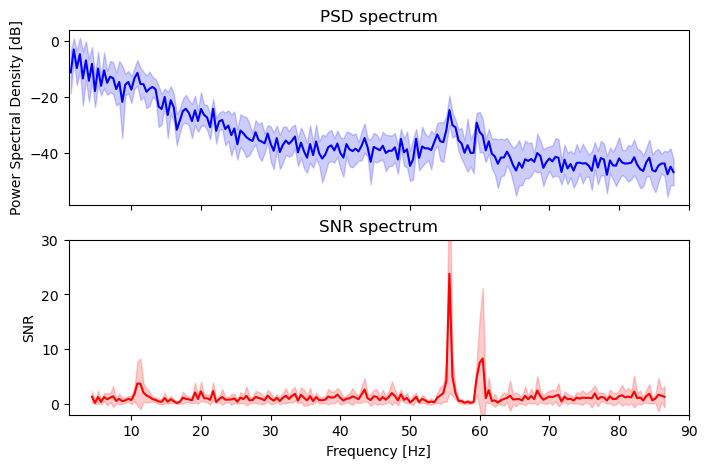

In [8]:
%matplotlib inline
fig, axes = plt.subplots(2, 1, sharex="all", sharey="none", figsize=(8, 5))
freq_range = range(
    np.where(np.floor(freqs) == 1.0)[0][0], np.where(np.ceil(freqs) == fmax - 1)[0][0]
)

psds_plot = 10 * np.log10(psds)
psds_mean = psds_plot.mean(axis=(0))[freq_range]
psds_std = psds_plot.std(axis=(0))[freq_range]
axes[0].plot(freqs[freq_range], psds_mean, color="b")
axes[0].fill_between(
    freqs[freq_range], psds_mean - psds_std, psds_mean + psds_std, color="b", alpha=0.2
)
axes[0].set(title="PSD spectrum", ylabel="Power Spectral Density [dB]")

# SNR spectrum
snr_mean = snrs.mean(axis=(0))[freq_range]
snr_std = snrs.std(axis=(0))[freq_range]

axes[1].plot(freqs[freq_range], snr_mean, color="r")
axes[1].fill_between(
    freqs[freq_range], snr_mean - snr_std, snr_mean + snr_std, color="r", alpha=0.2
)
axes[1].set(
    title="SNR spectrum",
    xlabel="Frequency [Hz]",
    ylabel="SNR",
    ylim=[-2, 30],
    xlim=[fmin, fmax],
)
fig.show()

In [9]:
# Extract SNR values at the stimulation frequency --- ??? a corriger + ?en fun du cued
stim_freq1 = 55.5
stim_freq2 = 60.0

# find index of frequency bin closest to stimulation frequency
i_bin_1 = np.argmin(abs(freqs - stim_freq1))
i_bin_2 = np.argmin(abs(freqs - stim_freq2))

# Apply the subset
snrs_target1 = snrs[:, i_bin_1]
snrs_target2 = snrs[:, i_bin_2]
print(f'SNR at {stim_freq1}Hz: {snrs_target1.mean()}')
print(f'SNR at {stim_freq2}Hz: {snrs_target2.mean()}')


SNR at 55.5Hz: 23.78592063273335
SNR at 60.0Hz: 7.546636116156449


### Comparing across cued conditions

In [10]:
# Simplify metadata
epochs_freqtag.metadata['flicker_sides'] = epochs_freqtag.metadata['flicker_sides'].replace({0: 6056, 1: 5660})
epochs_freqtag.metadata['cued_side'] = epochs_freqtag.metadata['cued_side'].replace({0: 'left', 1: 'right'})
condition_1 = ((epochs_freqtag.metadata['flicker_sides'] == 6056.0) & (epochs_freqtag.metadata['cued_side'] == 'left')) | \
    ((epochs_freqtag.metadata['flicker_sides'] == 5660.0) & (epochs_freqtag.metadata['cued_side'] == 'right'))
condition_2 = ((epochs_freqtag.metadata['flicker_sides'] == 6056.0) & (epochs_freqtag.metadata['cued_side'] == 'right')) | \
    ((epochs_freqtag.metadata['flicker_sides'] == 5660.0) & (epochs_freqtag.metadata['cued_side'] == 'left'))
epochs_freqtag.metadata['cued_tag'] = np.where(condition_1, 60, np.where(condition_2, 56, np.nan))

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_74834/2488109268.py:8: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in an error because the following channel names are missing:
['O4', 'O3']
Either fix your included names or explicitly pass ordered=False.
  spectrum = epochs_freqtag[query].copy().pick_channels(['Oz','O2','O4','O1','O3']).average().compute_psd(
/tmp/ipykernel_74834/2488109268.py:8: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  spectrum = epochs_freqtag[query].copy().pick_channels(['Oz','O2','O4','O1','O3']).average().compute_psd(
/tmp/ipykernel_74834/2488109268.py:8: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in an error because 

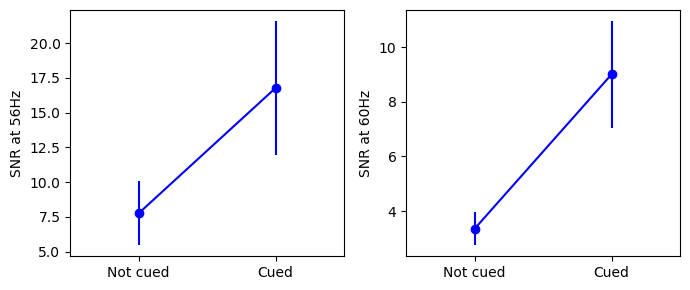

In [11]:
queries = ["cued_tag == 60", "cued_tag == 56"]
vals = {}
stim_freq1 = 55.5
stim_freq2 = 60.0

for query in queries:
    # Spectrum averaged over all trials
    spectrum = epochs_freqtag[query].copy().pick_channels(['Oz','O2','O4','O1','O3']).average().compute_psd(
        "welch",
        n_fft=int(sfreq * (tmax - tmin)),
        n_overlap=0,
        n_per_seg=None,
        tmin=tmin,
        tmax=tmax,
        fmin=fmin,
        fmax=fmax,
        window="boxcar",
        verbose=False,
    )
    psds, freqs = spectrum.get_data(return_freqs=True)
    bin_size = np.diff(freqs)[0]
    skip_nei = int((2 - bin_size/2)//bin_size)
    snrs = snr_spectrum(psds, noise_n_neighbor_freqs=2, noise_skip_neighbor_freqs = skip_nei)

    # find index of frequency bin closest to stimulation frequency
    i_bin_1 = np.argmin(abs(freqs - stim_freq1))
    i_bin_2 = np.argmin(abs(freqs - stim_freq2))
    
    # Apply the subset
    vals[query] = snrs[:, [i_bin_1,i_bin_2]]

fig, ax = plt.subplots(1,2, figsize=(7,3), sharex=False)
ax[0].plot([0,1], [(vals['cued_tag == 60'].mean(axis=(0)))[0], 
                 (vals['cued_tag == 56'].mean(axis=(0)))[0]], 'o', color='blue')
ax[0].errorbar([0,1], [(vals['cued_tag == 60'].mean(axis=(0)))[0], 
                 (vals['cued_tag == 56'].mean(axis=(0)))[0]],
               [(vals['cued_tag == 60'].std(axis=(0)))[0], 
                 (vals['cued_tag == 56'].std(axis=(0)))[0]], color='blue')
ax[0].set_ylabel('SNR at 56Hz')
ax[0].set_xticks([0,1], ['Not cued', 'Cued'])
ax[0].set_xlim(-.5, 1.5)
ax[1].plot([0,1], [(vals['cued_tag == 56'].mean(axis=(0)))[1],
                    vals['cued_tag == 60'].mean(axis=(0))[1]], 'o', color='blue')
ax[1].errorbar([0,1], [vals['cued_tag == 56'].mean(axis=(0))[1],
                        vals['cued_tag == 60'].mean(axis=(0))[1]],
              [vals['cued_tag == 56'].std(axis=(0))[1],
                vals['cued_tag == 60'].std(axis=(0))[1]], color='blue')
ax[1].set_xlim(-.5, 1.5)
ax[1].set_xticks([0,1], ['Not cued', 'Cued'])
ax[1].set_ylabel('SNR at 60Hz')
plt.tight_layout()
plt.show()

## 1.2 Topography of the SNR

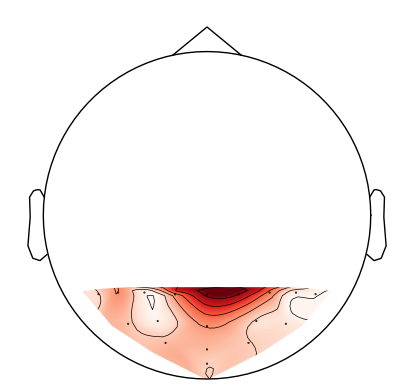

/tmp/ipykernel_74834/2059831999.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


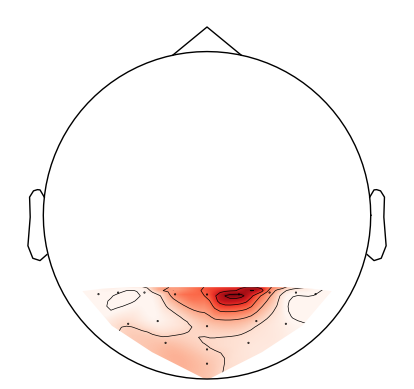

/tmp/ipykernel_74834/2059831999.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [12]:
# plot SNR topography
fig, ax = plt.subplots(1)
mne.viz.plot_topomap(snrs_target1, epochs.info, vlim=(1, None), axes=ax, extrapolate='local')
fig.show()
fig, ax = plt.subplots(1)
mne.viz.plot_topomap(snrs_target2, epochs.info, vlim=(1, None), axes=ax, extrapolate='local')
fig.show()

## 1.3 Coherence

(0.0, 50.0)

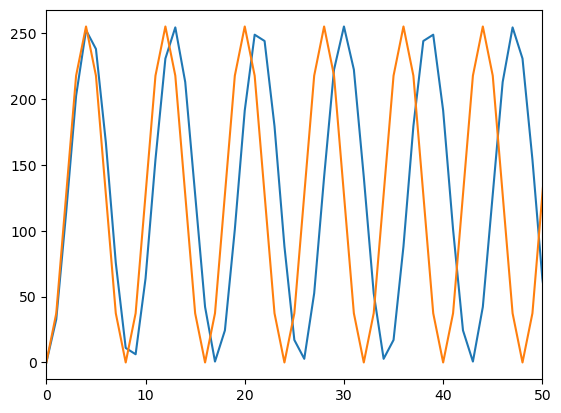

In [13]:
# Reproduce experimental frequency tags
def generate_freq_tag(tag_frequency):
    total_time = 10
    fps_q = 480 * 4
    lcm_fs = 8 * 120
    freq = tag_frequency
    
    if freq == 60 :
        flickers = (np.sin(np.linspace(-np.pi/2, 3*np.pi/2, 9)) + 1) / 2 
        tex_num = 8 
    elif freq == 56 : 
        flickers = (np.sin(np.linspace(-np.pi/2, -np.pi/2 + 14*2*np.pi, 121)) + 1) / 2 
        tex_num = 120
    else : raise ValueError('Tag frequency must be 56 or 60')
    
    flicker_signal = flickers[:-1]
    sin_wave_vals = np.tile(flicker_signal, (1, np.ceil(total_time * fps_q / tex_num).astype(int)))
    sin_wave_vals = sin_wave_vals[0][:-(len(sin_wave_vals[0]) % lcm_fs)] if (len(sin_wave_vals[0]) % lcm_fs) != 0 else sin_wave_vals[0]
    
    # Scaling luminance levels
    return sin_wave_vals * 255

# Visual check
plt.plot(generate_freq_tag(56))
plt.plot(generate_freq_tag(60))
plt.xlim(0,50)

In [14]:
def coherence(signalX, signalY, freq_of_interest=None):

    # Band-pass EEG (+/-1.9Hz) + crop the before cue part
    #signalX.filter(l_freq = freq_of_interest - 1.9, h_freq = freq_of_interest + 1.9).crop(tmin = 0)
    
    n = signalX.shape[1]  # number of trials

    # Hilbert transform
    signalXh = scipy.signal.hilbert(signalX)
    signalYh = scipy.signal.hilbert(signalY.T)

    # Magnitude
    mX = np.abs(signalXh.T)
    mY = np.abs(signalYh)

    # Phase difference
    phase_diff = np.angle(signalXh.T) - np.angle(signalYh)
    print(phase_diff)

    coh = np.zeros(signalY.shape[0])
    for t in range(signalY.shape[0]):
        num = (np.abs(np.sum(mX[:, t] * mY[:, t] * np.exp(1j * phase_diff[:, t])) / n) ** 2)
        denom =  (np.sum((mX[:, t] ** 2) * (mY[:, t] ** 2)) / n)
        coh[t] = num/denom
        print(f'{num}   {denom}\n')
        #coh[t] = (np.abs(np.sum(mX[:, t] * mY[:, t] * np.exp(1j * phase_diff[:, t])) / n) ** 2)\
        #/ (np.sum((mX[:, t] ** 2) * (mY[:, t] ** 2)) / n)

    return coh


In [15]:
# x = np.array([[1,1,1,2,2]])
# y = np.array([[6,7,6,5,6]])
# coherence(x.T,y.T)

In [16]:
# # Define parameters
# frequency = 60  # in Hz
# num_samples = 50

# # Generate time values
# time = np.linspace(0, 1, num_samples)

# # Generate sine wave
# x = np.array([np.sin(2 * np.pi * frequency * time)])


# # Define the parameters
# frequency = 40  # Frequency of the sine wave
# num_samples = 50  # Number of samples

# # Create an array of time points
# time = np.linspace(0, 1, num_samples)

# # Generate the sine wave
# y = np.array([np.sin(2 * np.pi * frequency * time)])

# coherence(x.T,y.T)

In [17]:
# plt.plot(x.T)
# plt.plot(y.T)

AttributeError: 'EpochsFIF' object has no attribute 'compute_tfr'

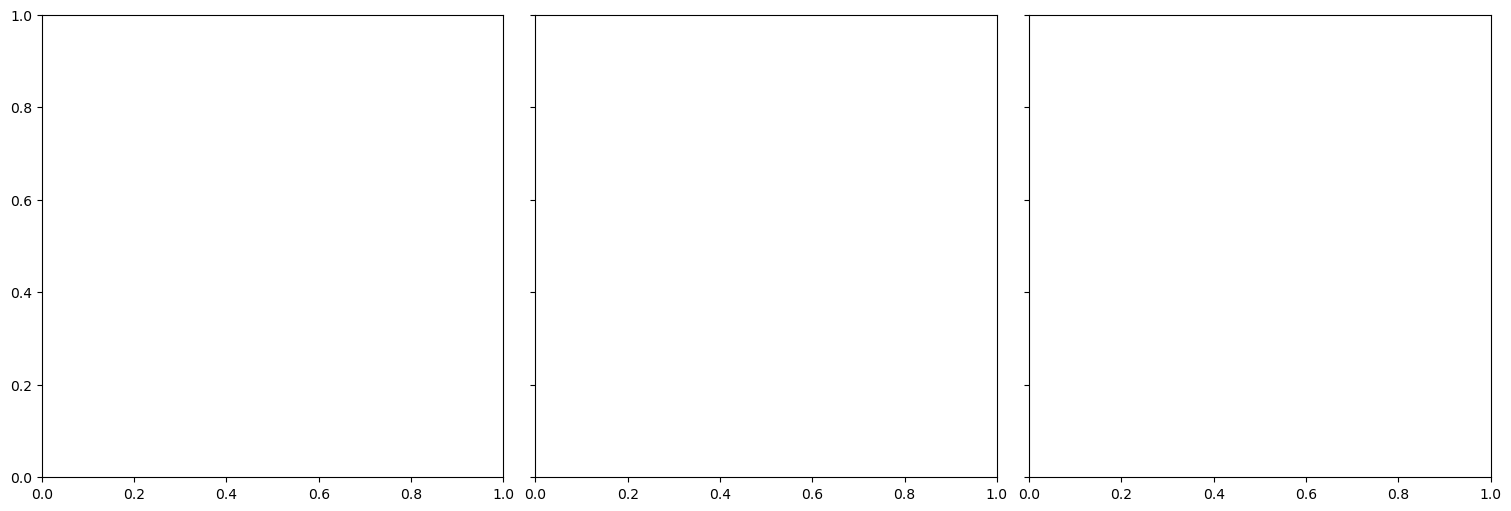

In [90]:
freqs = np.arange(5.0, 100.0, 3.0)
vmin, vmax = -3.0, 3.0  # Define our color limits.

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True, layout="constrained")
for n_cycles, time_bandwidth, ax, title in zip(
    [freqs / 2, freqs, freqs / 2],  # number of cycles
    [2.0, 4.0, 8.0],  # time bandwidth
    axs,
    [
        "Sim: Least smoothing, most variance",
        "Sim: Less frequency smoothing,\nmore time smoothing",
        "Sim: Less time smoothing,\nmore frequency smoothing",
    ],
):
    power = epochs_freqtag.compute_tfr(
        method="multitaper",
        freqs=freqs,
        n_cycles=n_cycles,
        time_bandwidth=time_bandwidth,
        return_itc=False,
        average=True,
    )
    ax.set_title(title)
    # Plot results. Baseline correct based on first 100 ms.
    power.plot(
        [0],
        baseline=(0.0, 0.1),
        mode="mean",
        vlim=(vmin, vmax),
        axes=ax,
        show=False,
        colorbar=False,
    )


## 1.4 Cross-correlation

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_74834/525394275.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  eeg = epochs.copy().pick_channels(electrodes).resample(sfreq = 1920)


Setting up high-pass filter at 54 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 54.00
- Lower transition bandwidth: 13.50 Hz (-6 dB cutoff frequency: 47.25 Hz)
- Filter length: 471 samples (0.245 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
/tmp/ipykernel_74834/525394275.py:23: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  eeg_arr = eeg[f"cued_tag == {freq_cued_tag} & cued_side == '{display_side_cued_tag}'"].get_data()
/tmp/ipykernel_74834/525394275.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  eeg = epochs.copy().pick_channels(electrodes).resample(sfreq = 1920)


Setting up high-pass filter at 54 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 54.00
- Lower transition bandwidth: 13.50 Hz (-6 dB cutoff frequency: 47.25 Hz)
- Filter length: 471 samples (0.245 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
/tmp/ipykernel_74834/525394275.py:23: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  eeg_arr = eeg[f"cued_tag == {freq_cued_tag} & cued_side == '{display_side_cued_tag}'"].get_data()
/tmp/ipykernel_74834/525394275.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  eeg = epochs.copy().pick_channels(electrodes).resample(sfreq = 1920)


Setting up high-pass filter at 54 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 54.00
- Lower transition bandwidth: 13.50 Hz (-6 dB cutoff frequency: 47.25 Hz)
- Filter length: 471 samples (0.245 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
/tmp/ipykernel_74834/525394275.py:23: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  eeg_arr = eeg[f"cued_tag == {freq_cued_tag} & cued_side == '{display_side_cued_tag}'"].get_data()
/tmp/ipykernel_74834/525394275.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  eeg = epochs.copy().pick_channels(electrodes).resample(sfreq = 1920)


Setting up high-pass filter at 54 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 54.00
- Lower transition bandwidth: 13.50 Hz (-6 dB cutoff frequency: 47.25 Hz)
- Filter length: 471 samples (0.245 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
/tmp/ipykernel_74834/525394275.py:23: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  eeg_arr = eeg[f"cued_tag == {freq_cued_tag} & cued_side == '{display_side_cued_tag}'"].get_data()


Text(0, 0.5, '|Cor| EEG/tag 60')

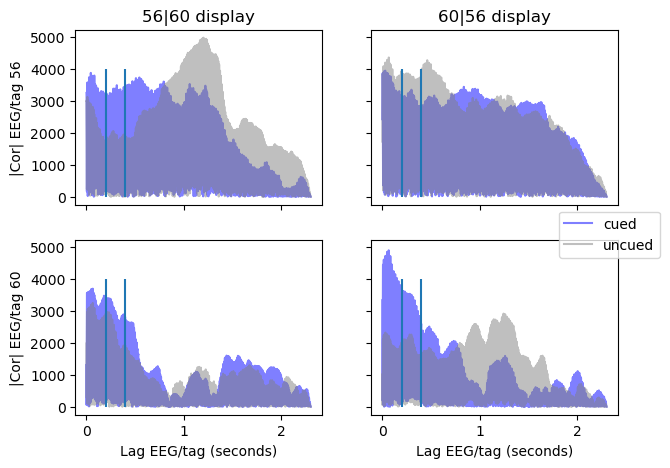

In [18]:
# Prepare EEG arrays
def freqtag_preproc(epochs, freq_cued_tag, display_side_cued_tag, electrodes=None):
    '''
    Returns an array (trial*electrode*timepoint) of further pre-processed eeg data :
    
    Downsamples (1920Hz) and high passes (50Hz) EEG epochs.
    If electrodes isn't None selects the provided list.
    Selects the time window from cue onset to trial end.
    Selects the trials when freq_cued_tag was cued and displayed on display_side_cued_tag

    display_side_cued_tag : 'left' or 'right'
    '''
    # Converge EEG and tag sampling frequencies 
    # Downsample EEG from 2048 to 1920Hz + select elec
    if electrodes is None:
        eeg = epochs.copy().resample(sfreq = 1920)
    else:
        eeg = epochs.copy().pick_channels(electrodes).resample(sfreq = 1920)
   
    # High-pass (50Hz) EEG data + crop the before cue part
    eeg.filter(l_freq=54, h_freq = None).crop(tmin = 0)
    
    eeg_arr = eeg[f"cued_tag == {freq_cued_tag} & cued_side == '{display_side_cued_tag}'"].get_data()

    return eeg_arr
  

eeg_cue56R = freqtag_preproc(epochs_freqtag, 56, 'right', electrodes = electrodes_kabir)
eeg_cue56L = freqtag_preproc(epochs_freqtag, 56, 'left', electrodes = electrodes_kabir)
eeg_cue60R = freqtag_preproc(epochs_freqtag, 60, 'right', electrodes = electrodes_kabir)
eeg_cue60L = freqtag_preproc(epochs_freqtag, 60, 'left', electrodes = electrodes_kabir)

# Prepare tags arrays
# Upsample tag from 480 to 1920Hz (by repetition rather than inference)
tag_60 = np.repeat(generate_freq_tag(60),4)
tag_56 = np.repeat(generate_freq_tag(56),4)
# Select only the tag part that was displayed during the epoch
tag_60 = tag_60[:eeg_cue56R.shape[-1]] 
tag_56 = tag_56[:eeg_cue56R.shape[-1]]

# Get cross-correlation 
def cross_cor(eeg_arr, cued_tag_arr, uncued_tag_arr):
    '''
    Returns 2 matrices (trial*electrode*lag (in time steps between EEG start and tag start) of corr values. 
    The first matrice contains the EEG/cued_tag corr, the second the EEG/tag2 corr
    '''
    cross_corr_tag1 = np.zeros(eeg_arr.shape)
    cross_corr_tag2 = np.zeros(eeg_arr.shape)
    
    for trial in range(eeg_arr.shape[0]):
        for elec in range(eeg_arr.shape[1]):
            # Standardize eeg trial data
            trial_data = (eeg_arr[trial,elec,:]-eeg_arr[trial,elec,:].mean())/eeg_arr[trial,elec,:].std()
            # Assume the tag can only appear in the EEG when its screen display has started (crop the first tag_length-1 outputs)
            cross_corr_tag1[trial, elec] = scipy.signal.correlate(trial_data, cued_tag_arr, mode='full')[len(cued_tag_arr)- 1:]
            cross_corr_tag2[trial, elec] = scipy.signal.correlate(trial_data, uncued_tag_arr, mode='full')[len(uncued_tag_arr)- 1:]

    
    return cross_corr_tag1, cross_corr_tag2 


cor56_5660_cued, cor60_5660_notcued = cross_cor(eeg_cue56L, tag_56, tag_60)
cor60_5660_cued, cor56_5660_notcued = cross_cor(eeg_cue60R, tag_60, tag_56)

cor56_6056_cued, cor60_6056_notcued = cross_cor(eeg_cue56R, tag_56, tag_60)
cor60_6056_cued, cor56_6056_notcued = cross_cor(eeg_cue60L, tag_60, tag_56)

# Plot
x_vals = np.arange(cor56_5660_cued.shape[-1])*(1/1920)
fig, ax = plt.subplots(2,2, sharey=True, sharex=True, figsize=(7,5))

ax[0,0].plot(x_vals, np.abs(cor56_5660_cued.mean(axis=(0,1)).T), alpha=.5, color='blue')
ax[0,0].plot(x_vals, np.abs(cor56_5660_notcued.mean(axis=(0,1)).T), alpha=.5, color='grey')
ax[1,0].plot(x_vals, np.abs(cor60_5660_cued.mean(axis=(0,1)).T), alpha=.5, color='blue')
ax[1,0].plot(x_vals, np.abs(cor60_5660_notcued.mean(axis=(0,1)).T), alpha=.5, color='grey')

ax[0,1].plot(x_vals, np.abs(cor56_6056_cued.mean(axis=(0,1)).T), alpha=.5, color='blue')
ax[0,1].plot(x_vals, np.abs(cor56_6056_notcued.mean(axis=(0,1)).T), alpha=.5, color='grey')
ax[1,1].plot(x_vals, np.abs(cor60_6056_cued.mean(axis=(0,1)).T), alpha=.5, color='blue', label='cued')
ax[1,1].plot(x_vals, np.abs(cor60_6056_notcued.mean(axis=(0,1)).T), alpha=.5, color='grey', label='uncued')

for ax_i in ax:
    for ax_j in ax_i:
        ax_j.vlines([.200,.400], [0,0], [4000,4000])
ax[0,0].set_title('56|60 display')
ax[0,1].set_title('60|56 display')
ax[1,1].legend(bbox_to_anchor = (1.2,1.2))
ax[1,0].set_xlabel('Lag EEG/tag (seconds)')
ax[1,1].set_xlabel('Lag EEG/tag (seconds)')
ax[0, 0].set_ylabel('|Cor| EEG/tag 56')
ax[1, 0].set_ylabel('|Cor| EEG/tag 60')


In [80]:
sfreq = 1920
eeg_arr = epochs_freqtag.copy().filter(l_freq=54, h_freq = None).crop(tmin = 0).resample(sfreq = sfreq).get_data(copy=False)
# make time the first dimension
eeg_arr = np.transpose(eeg_arr, axes=(2,0,1))
n_samples, n_trials, n_channels = eeg_arr.shape
# Prepare model data (make time the first dimension)
freq_tags = np.zeros((n_samples, n_trials, 2))
i = 0
tag1 = np.repeat(generate_freq_tag(60),4)
tag2 = np.repeat(generate_freq_tag(56),4)
for index, row in epochs_freqtag.metadata.iterrows():
    freq_tags[:, i] = np.array([tag1[:n_samples], tag2[:n_samples]]).T
    #    freq_tags[i] = np.where(row.cued_side == 56.0, tag_56 ,tag_60)[:n_samples]

    i += 1
freq_tags = freq_tags

Setting up high-pass filter at 54 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 54.00
- Lower transition bandwidth: 13.50 Hz (-6 dB cutoff frequency: 47.25 Hz)
- Filter length: 501 samples (0.245 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    1.1s


In [81]:
freq_tags.shape

(4416, 221, 2)

split 1 / 3
Fitting 221 epochs, 2 channels


  0%|          | Sample : 0/1105 [00:00<?,       ?it/s]

split 2 / 3
Fitting 221 epochs, 2 channels


  0%|          | Sample : 0/1105 [00:00<?,       ?it/s]

split 3 / 3
Fitting 221 epochs, 2 channels


  0%|          | Sample : 0/1105 [00:00<?,       ?it/s]

[Text(0.5, 1.0, 'Mean prediction score'),
 Text(0.5, 0, 'Channel'),
 Text(0, 0.5, 'Score ($r$)')]

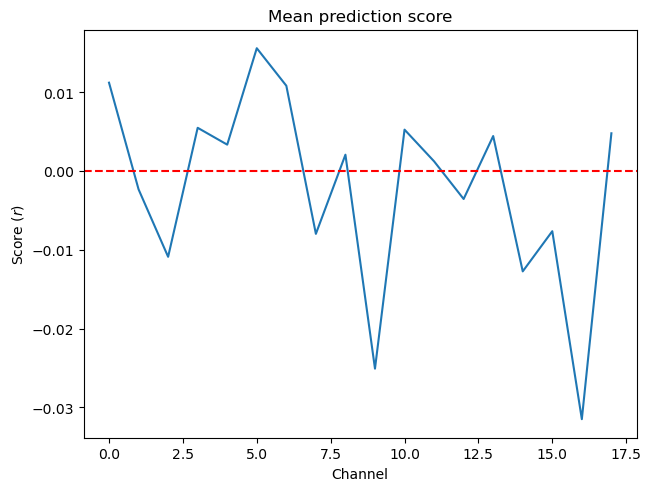

In [82]:
tmin, tmax = 0, 0.6
# Initialize the model
rf = ReceptiveField(
    tmin, tmax, sfreq, estimator=1.0, scoring="corrcoef"
)
# We'll have (tmax - tmin) * sfreq delays
# and an extra 2 delays since we are inclusive on the beginning / end index
n_delays = int((tmax - tmin) * sfreq) + 2

n_splits = 3
cv = KFold(n_splits)


# Iterate through splits, fit the model, and predict/test on held-out data
coefs = np.zeros((n_splits, n_channels, n_delays-1))
scores = np.zeros((n_splits, n_channels))
for ii, (train, test) in enumerate(cv.split(freq_tags)):
    print(f"split {ii + 1} / {n_splits}")
    rf.fit(freq_tags[train], eeg_arr[train])
    scores[ii] = rf.score(freq_tags[test], eeg_arr[test])
    # coef_ is shape (n_outputs, n_features, n_delays). we only have 1 feature
    coefs[ii] = rf.coef_[:, 0, :]
times = rf.delays_ / float(rf.sfreq)

# Average scores and coefficients across CV splits
mean_coefs = coefs.mean(axis=0)
mean_scores = scores.mean(axis=0)

# Plot mean prediction scores across all channels
fig, ax = plt.subplots(layout="constrained")
ix_chs = np.arange(n_channels)
ax.plot(ix_chs, mean_scores)
ax.axhline(0, ls="--", color="r")
ax.set(title="Mean prediction score", xlabel="Channel", ylabel="Score ($r$)")


[Text(0.5, 1.0, 'Topomap of model coefficients\nfor delay 0.0175')]

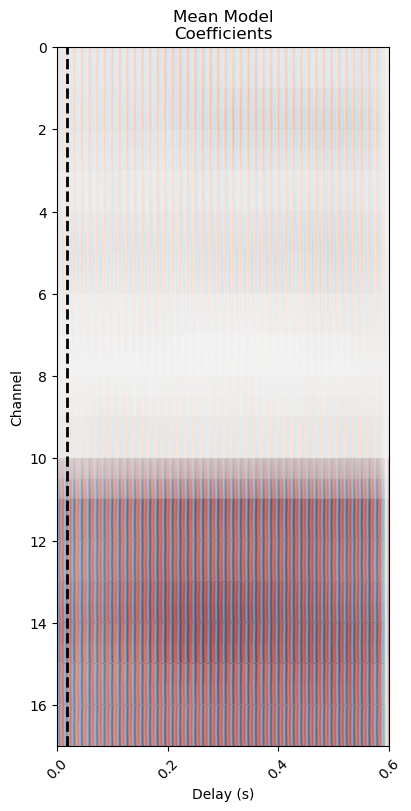

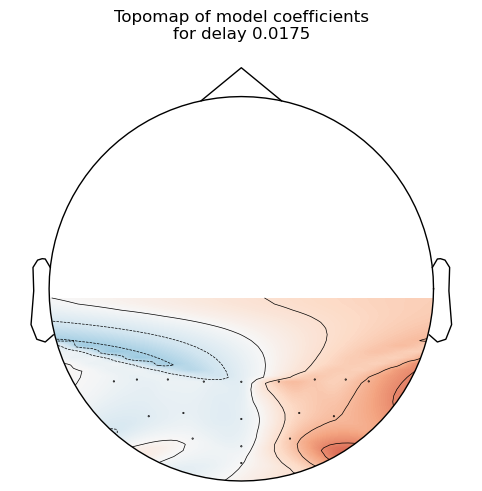

In [83]:
# Print mean coefficients across all time delays / channels (see Fig 1)
time_plot = 0.0175  # For highlighting a specific time.
fig, ax = plt.subplots(figsize=(4, 8), layout="constrained")
max_coef = mean_coefs.max()
ax.pcolormesh(
    times,
    ix_chs,
    mean_coefs,
    cmap="RdBu_r",
    vmin=-max_coef,
    vmax=max_coef,
    shading="gouraud",
)
ax.axvline(time_plot, ls="--", color="k", lw=2)
ax.set(
    xlabel="Delay (s)",
    ylabel="Channel",
    title="Mean Model\nCoefficients",
    xlim=times[[0, -1]],
    ylim=[len(ix_chs) - 1, 0],
    xticks=np.arange(tmin, tmax + 0.2, 0.2),
)
plt.setp(ax.get_xticklabels(), rotation=45)

# Make a topographic map of coefficients for a given delay (see Fig 2C)
ix_plot = np.argmin(np.abs(time_plot - times))
fig, ax = plt.subplots(layout="constrained")
mne.viz.plot_topomap(
    mean_coefs[:, ix_plot], pos=epochs_freqtag.info, axes=ax, show=False, vlim=(-max_coef, max_coef),extrapolate='box'
)
ax.set(title="Topomap of model coefficients\nfor delay %s" % time_plot)

In [84]:
sr = ReceptiveField(
    tmin,
    tmax,
    sfreq,
    feature_names=epochs_freqtag.ch_names,
    estimator=1e4,
    scoring="corrcoef",
    patterns=True,
)
# We'll have (tmax - tmin) * sfreq delays
# and an extra 2 delays since we are inclusive on the beginning / end index
n_delays = int((tmax - tmin) * sfreq) + 2

n_splits = 3
cv = KFold(n_splits)

# Iterate through splits, fit the model, and predict/test on held-out data
coefs = np.zeros((n_splits, n_channels, n_delays-1))
patterns = coefs.copy()
scores = np.zeros((n_splits,))
for ii, (train, test) in enumerate(cv.split(freq_tags)):
    print(f"split {ii + 1} / {n_splits}")
    sr.fit(eeg_arr[train], freq_tags[train])
    scores[ii] = sr.score(eeg_arr[test], freq_tags[test])[0]
    # coef_ is shape (n_outputs, n_features, n_delays). We have 128 features
    coefs[ii] = sr.coef_[0, :, :]
    patterns[ii] = sr.patterns_[0, :, :]
times = sr.delays_ / float(sr.sfreq)

# Average scores and coefficients across CV splits
mean_coefs = coefs.mean(axis=0)
mean_patterns = patterns.mean(axis=0)
mean_scores = scores.mean(axis=0)
max_coef = np.abs(mean_coefs).max()
max_patterns = np.abs(mean_patterns).max()

split 1 / 3
Fitting 221 epochs, 18 channels


  0%|          | Sample : 0/41769 [00:00<?,       ?it/s]

split 2 / 3
Fitting 221 epochs, 18 channels


  0%|          | Sample : 0/41769 [00:00<?,       ?it/s]

split 3 / 3
Fitting 221 epochs, 18 channels


  0%|          | Sample : 0/41769 [00:00<?,       ?it/s]

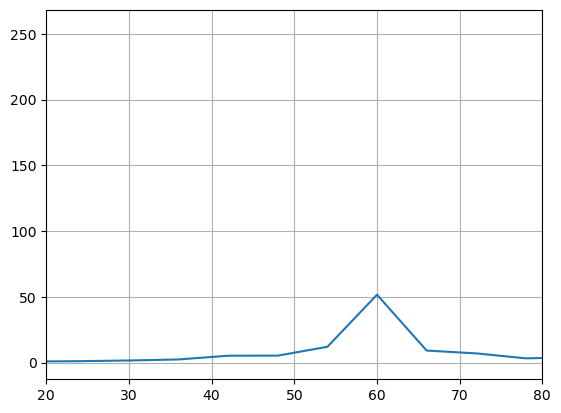

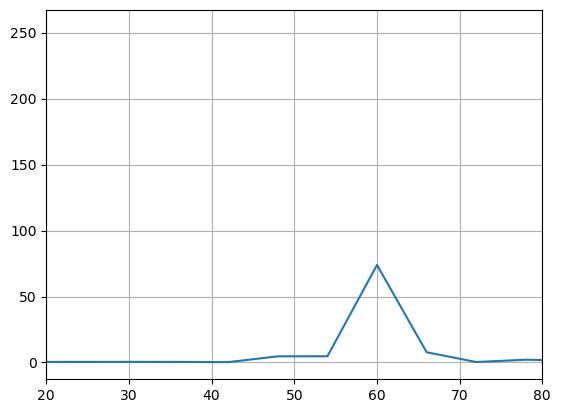

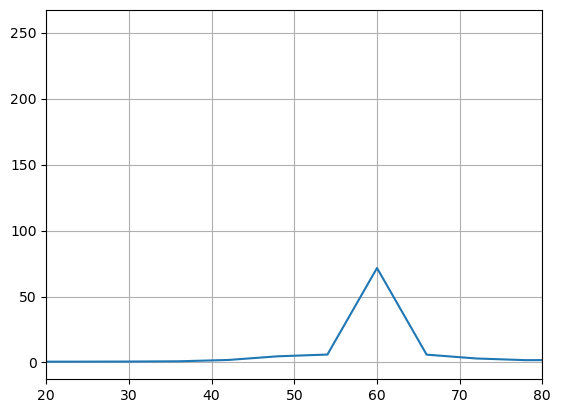

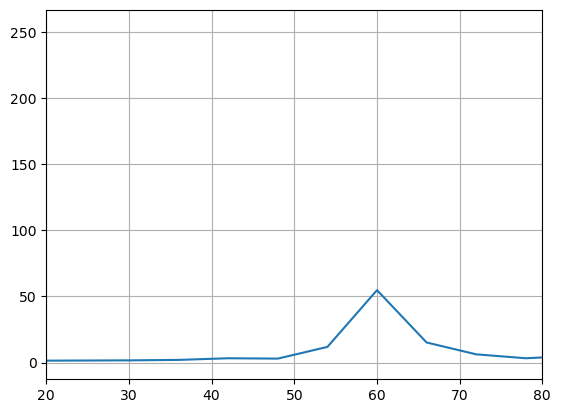

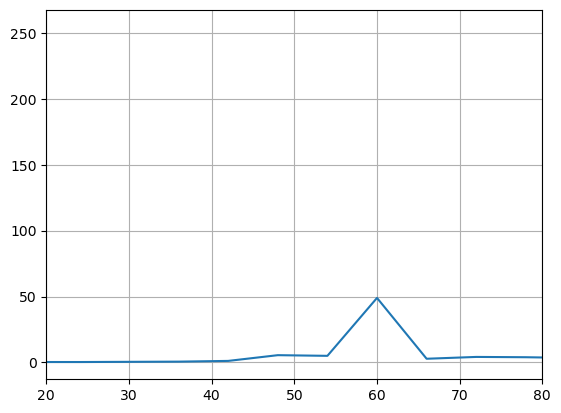

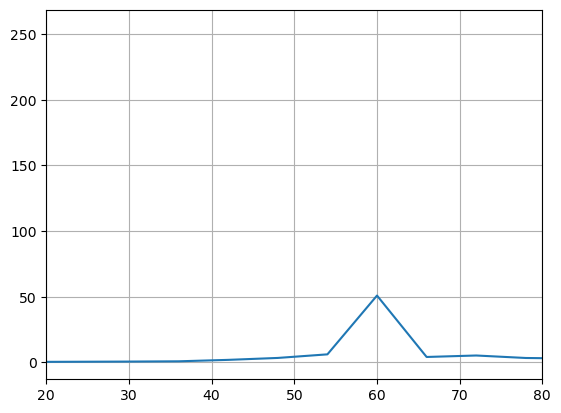

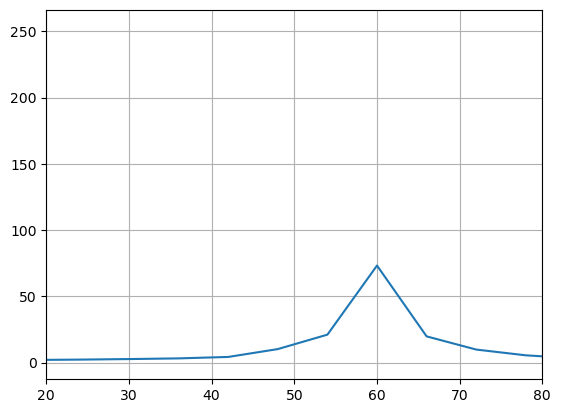

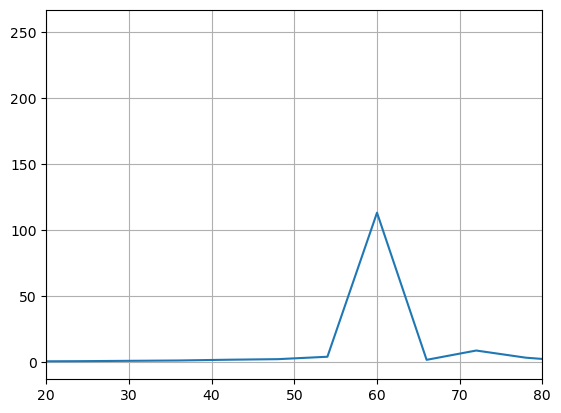

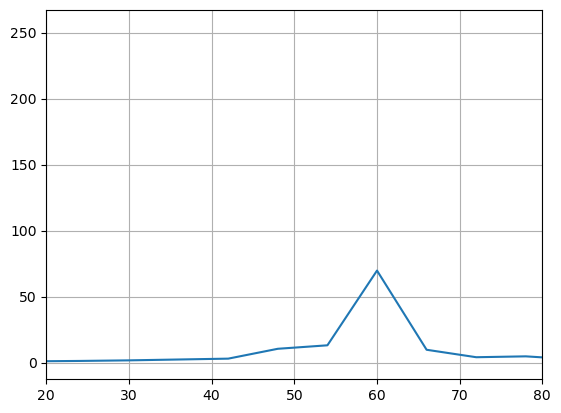

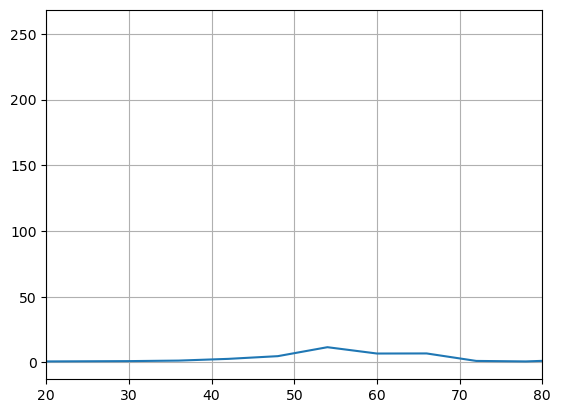

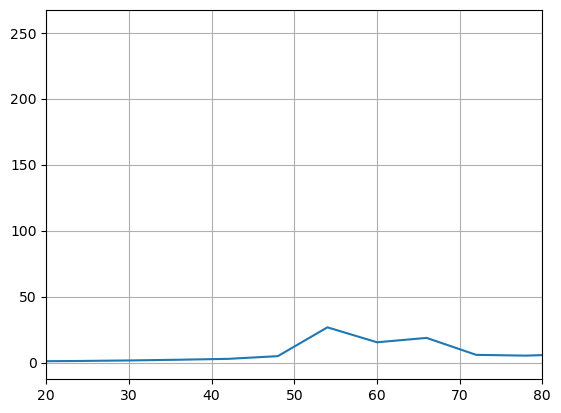

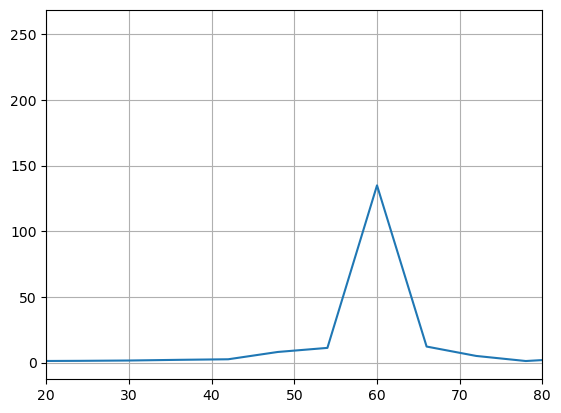

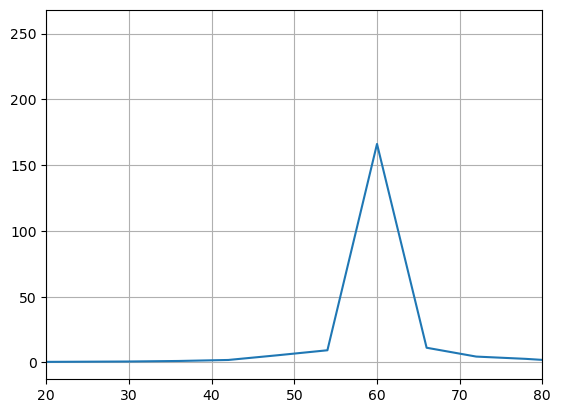

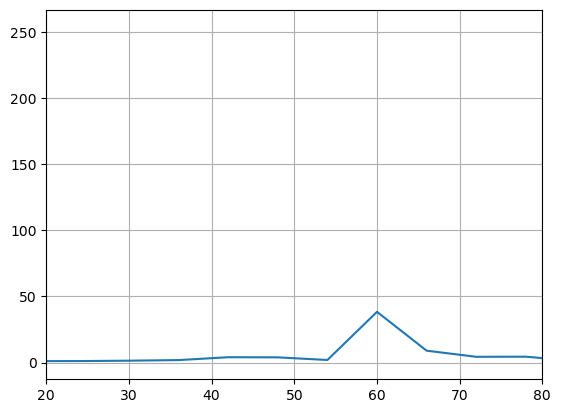

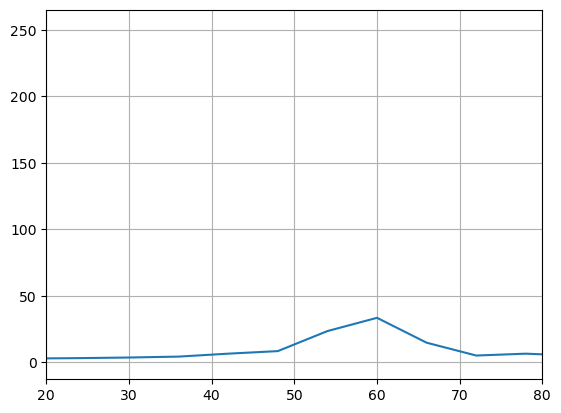

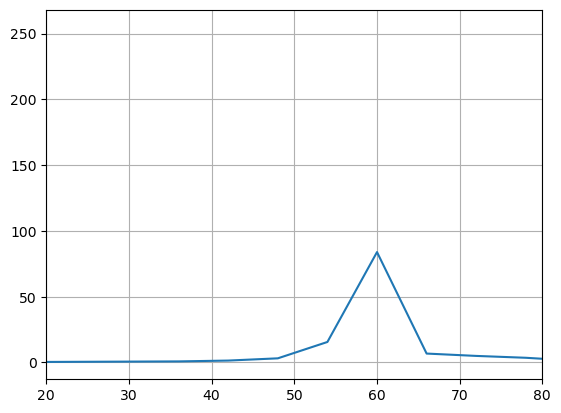

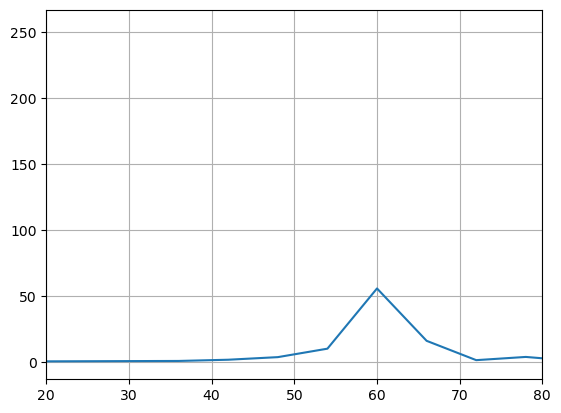

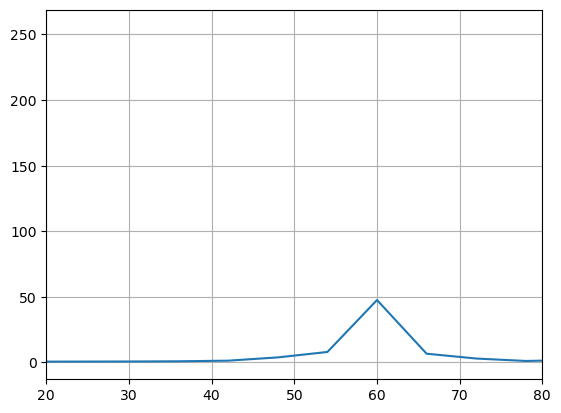

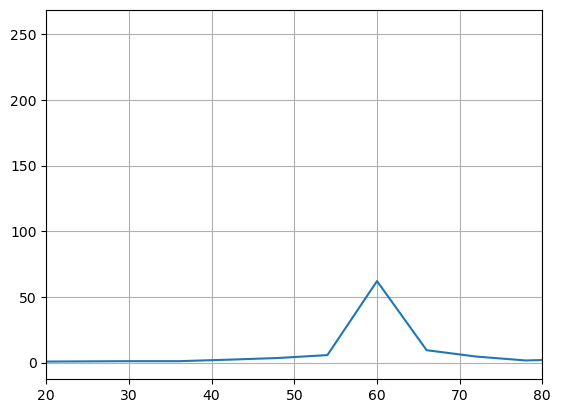

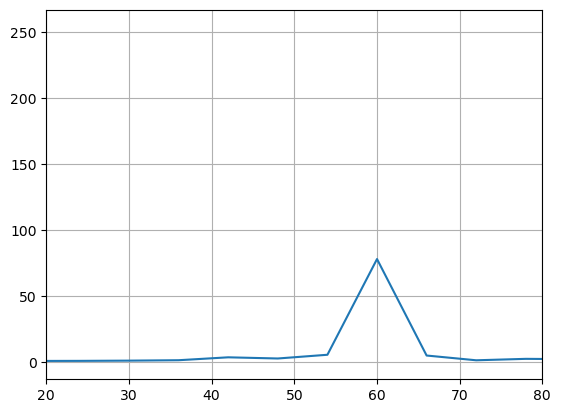

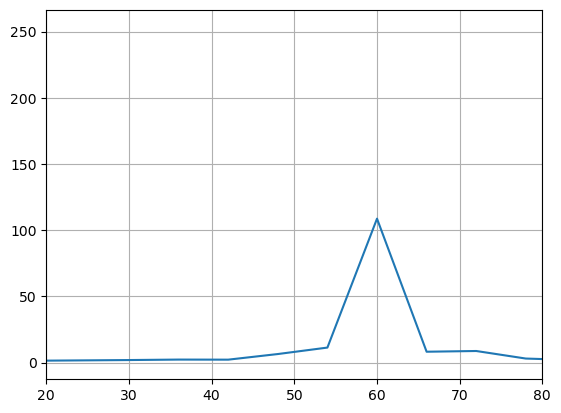

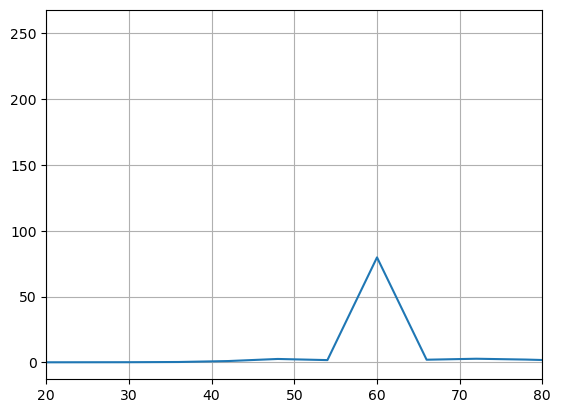

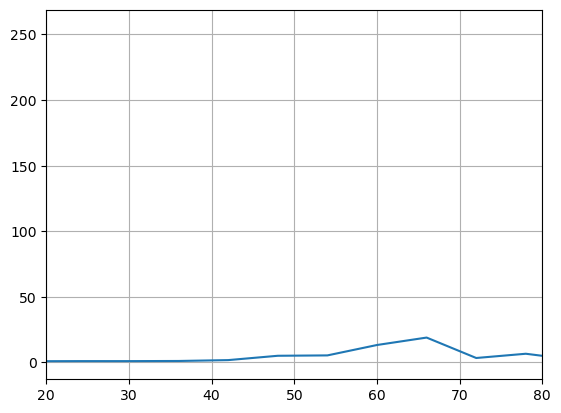

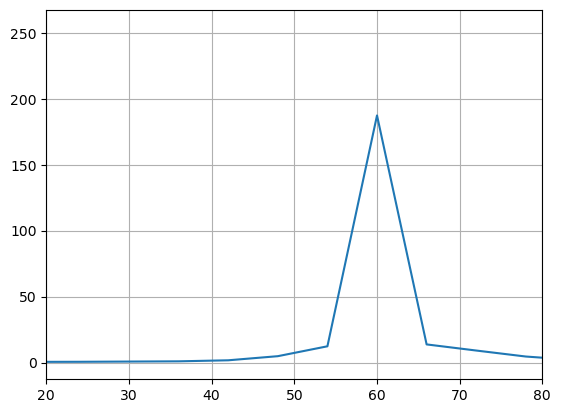

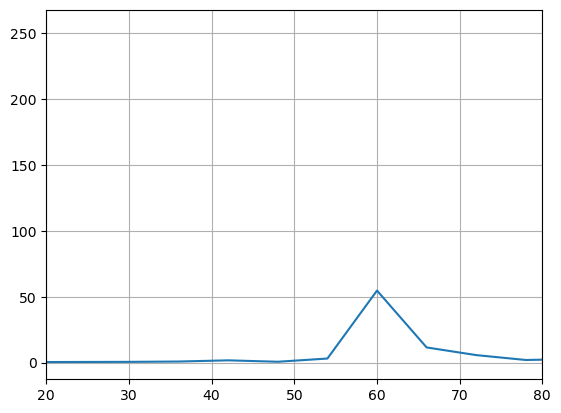

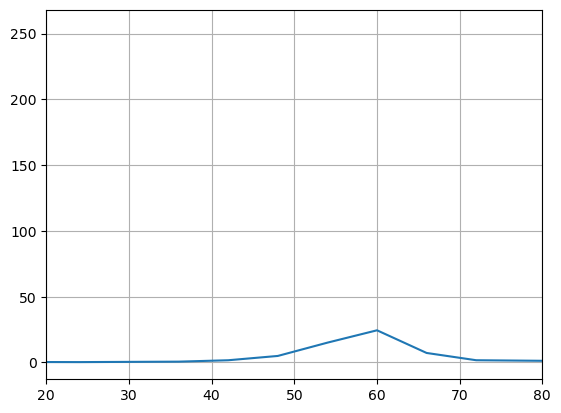

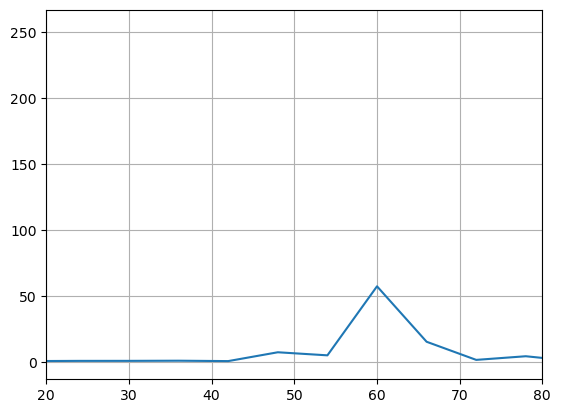

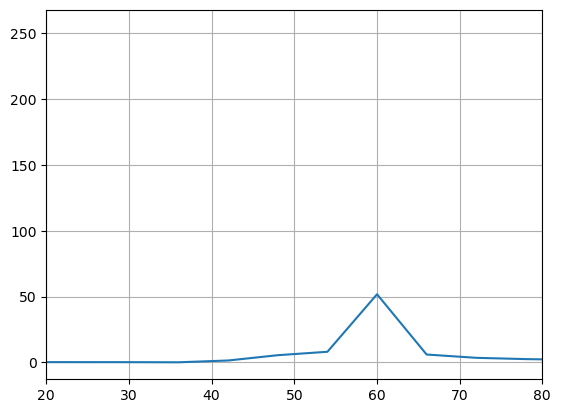

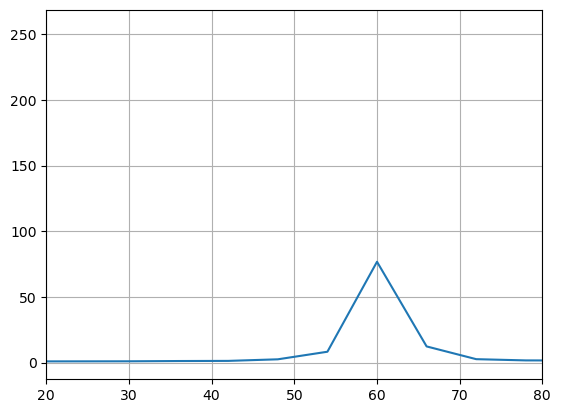

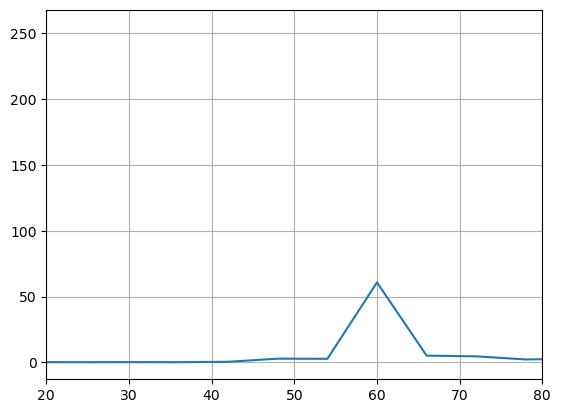

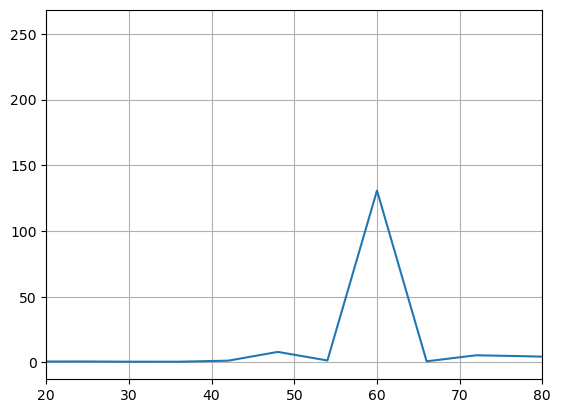

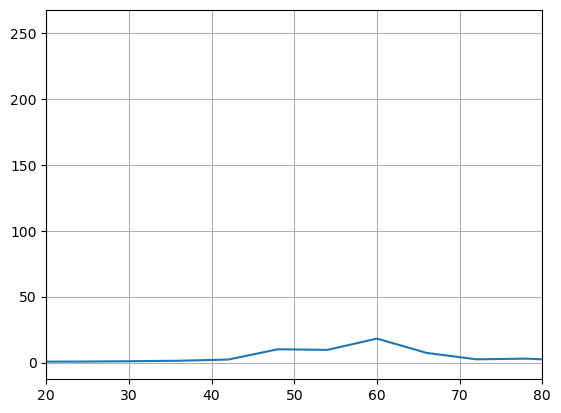

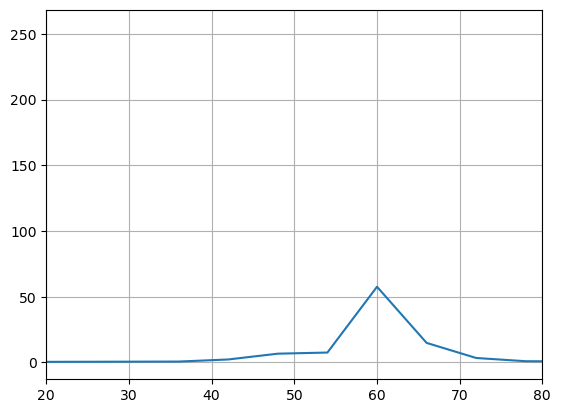

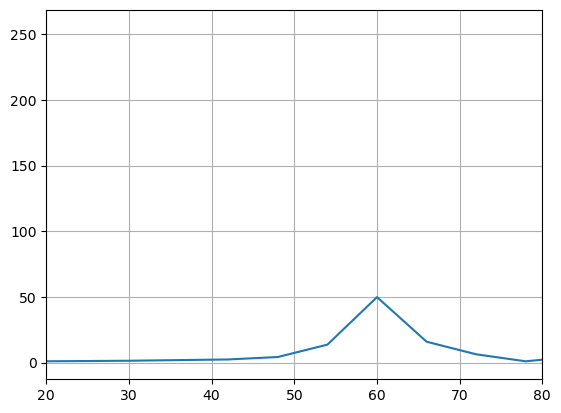

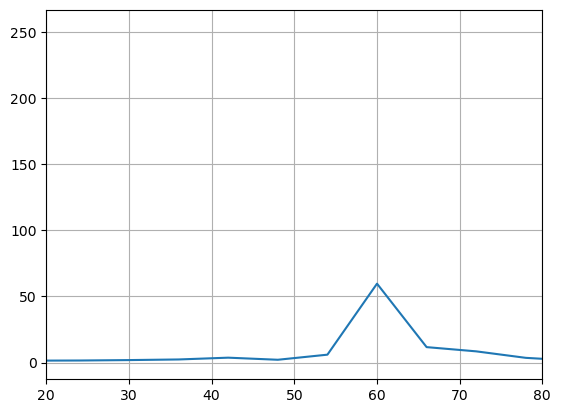

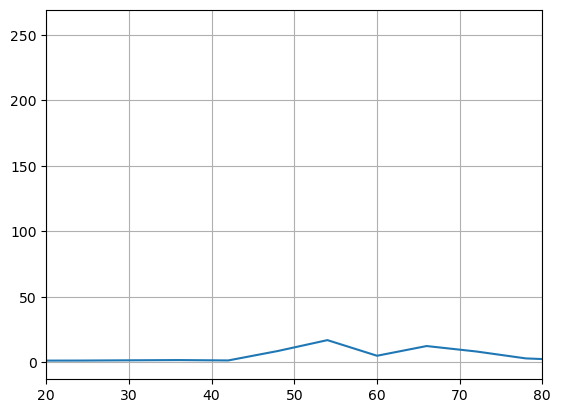

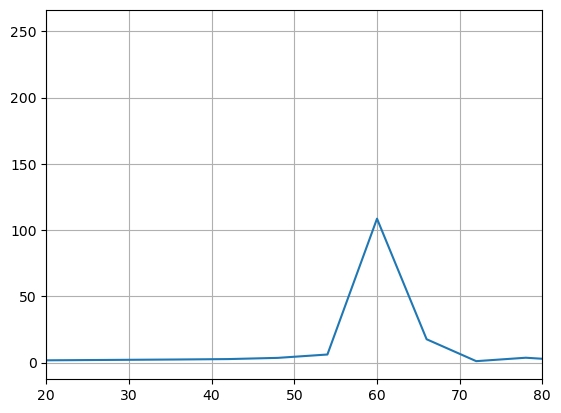

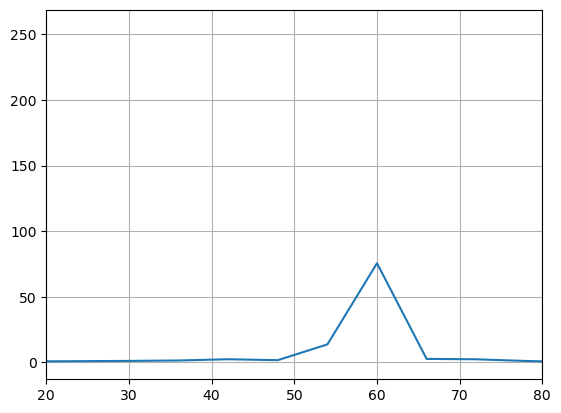

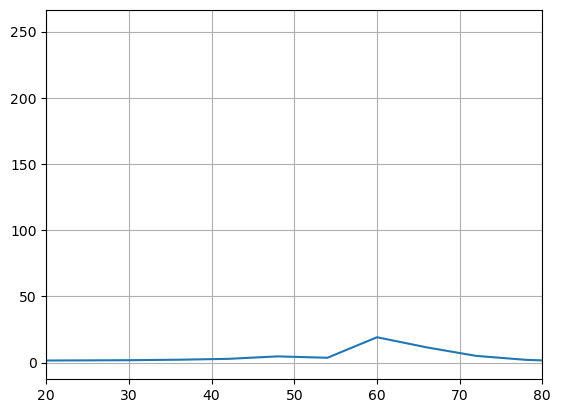

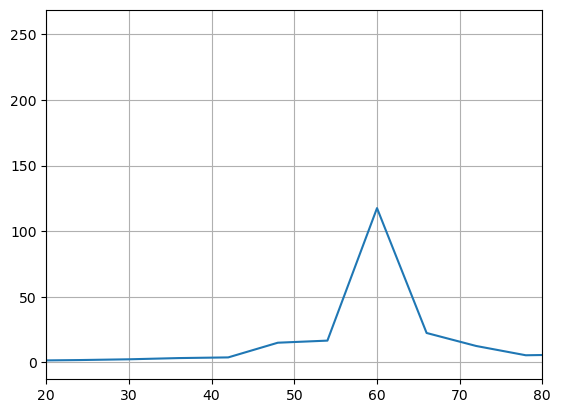

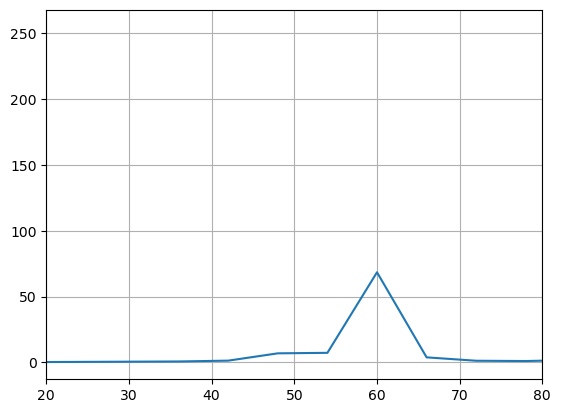

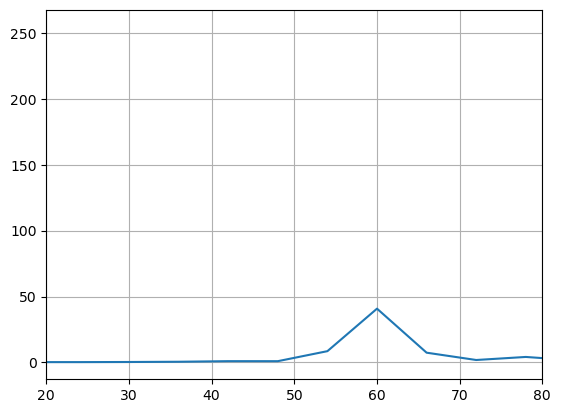

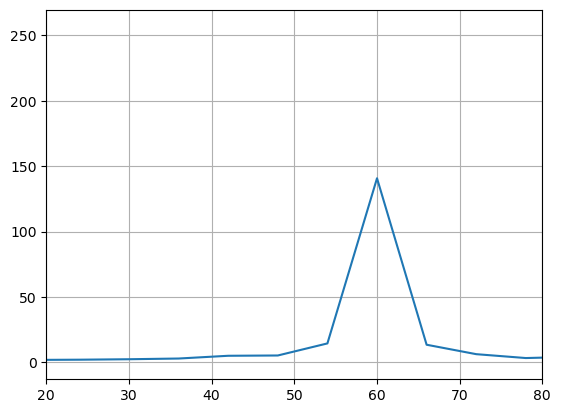

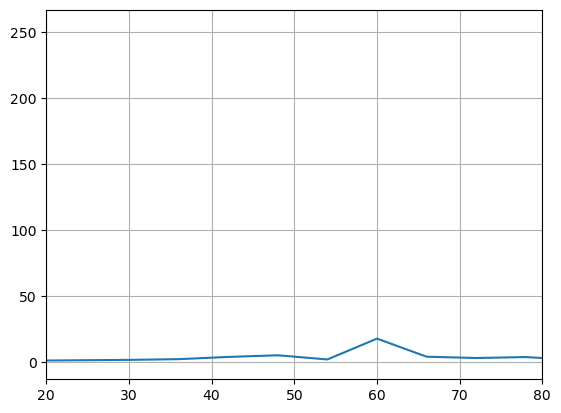

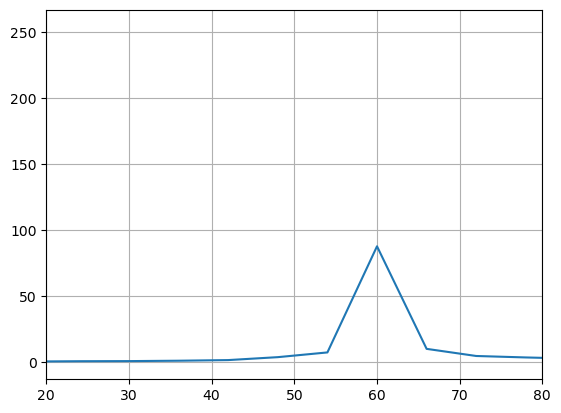

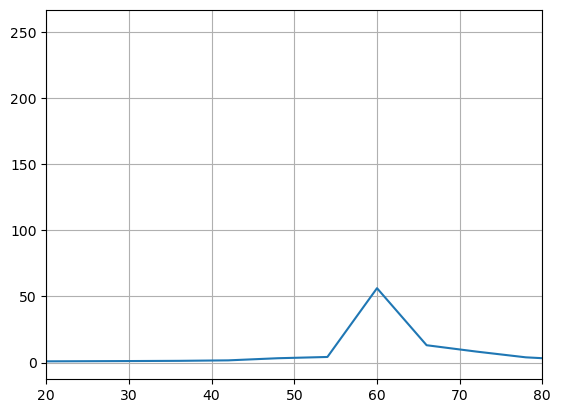

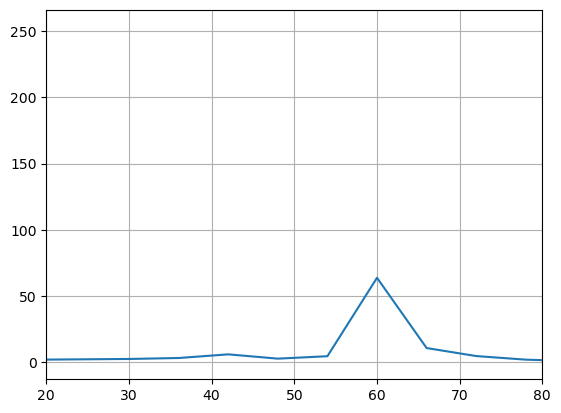

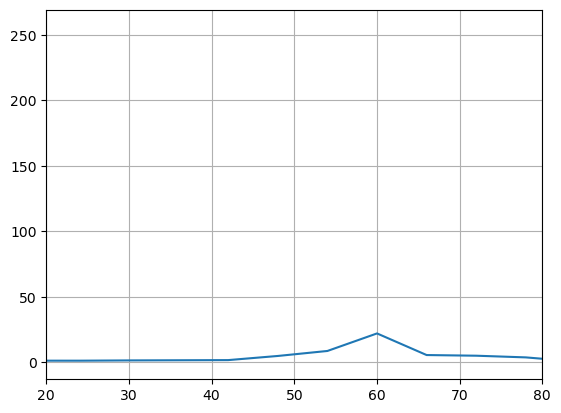

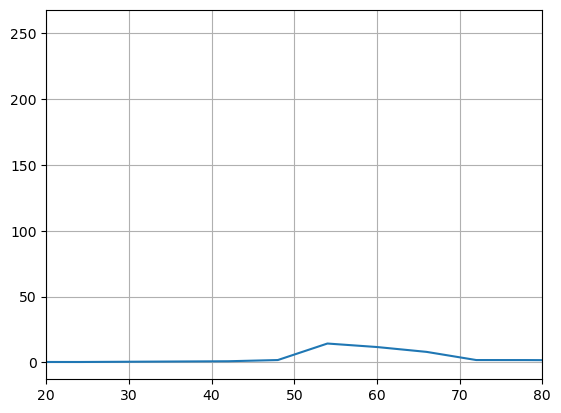

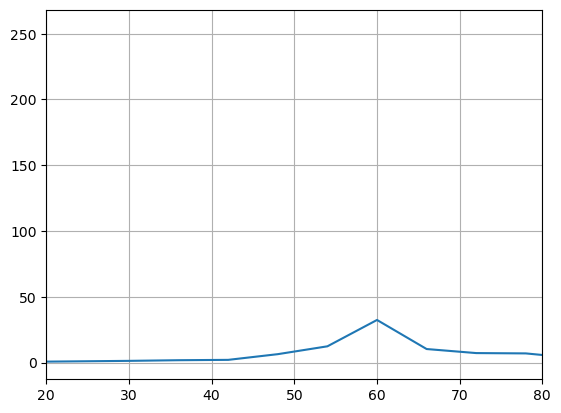

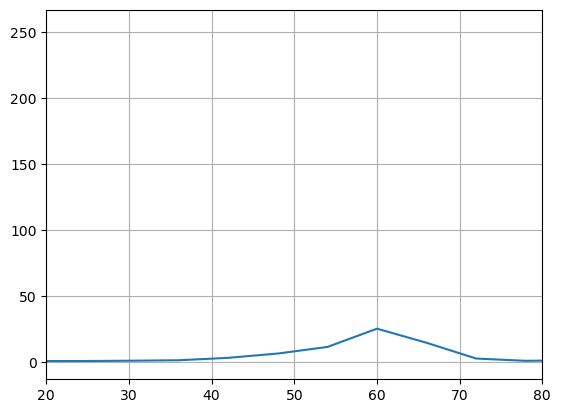

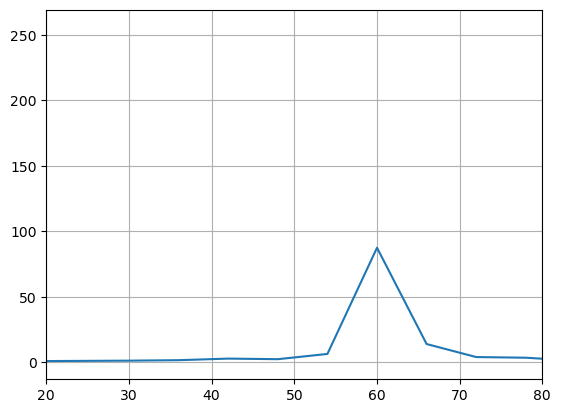

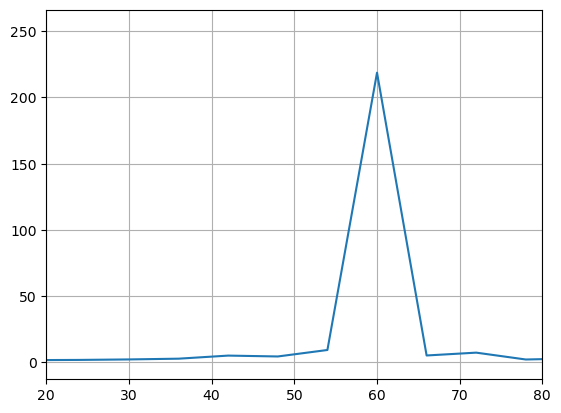

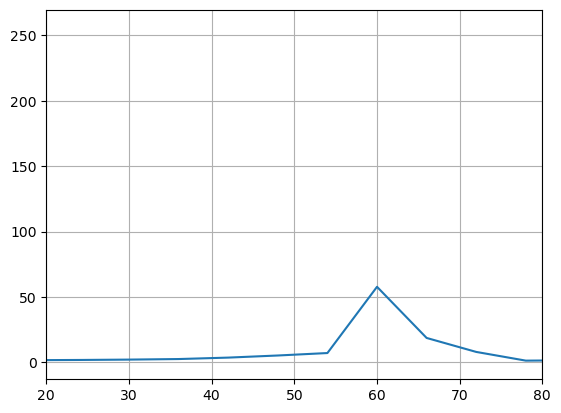

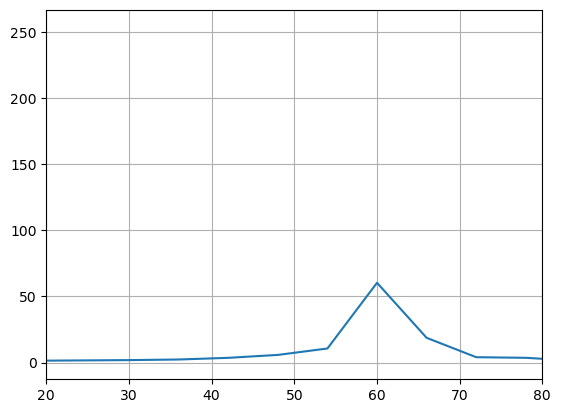

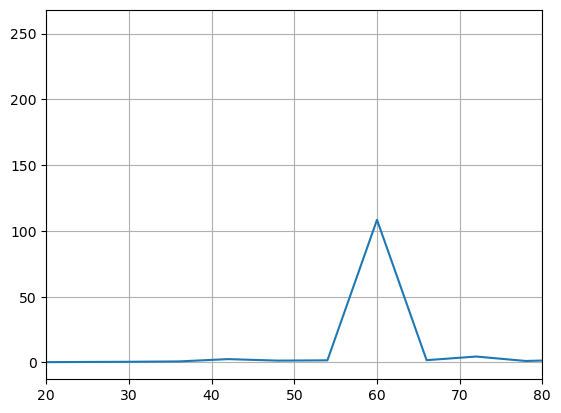

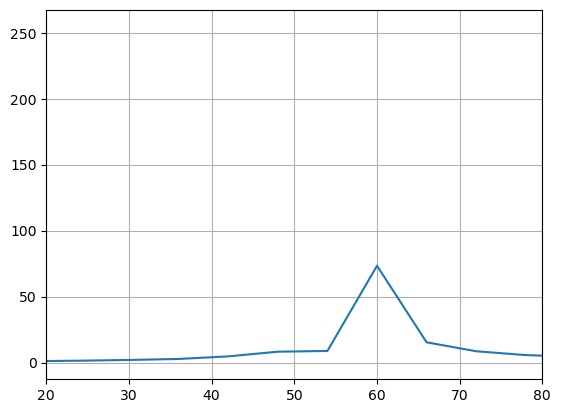

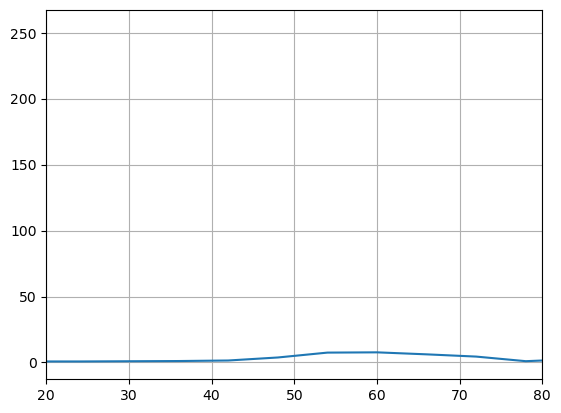

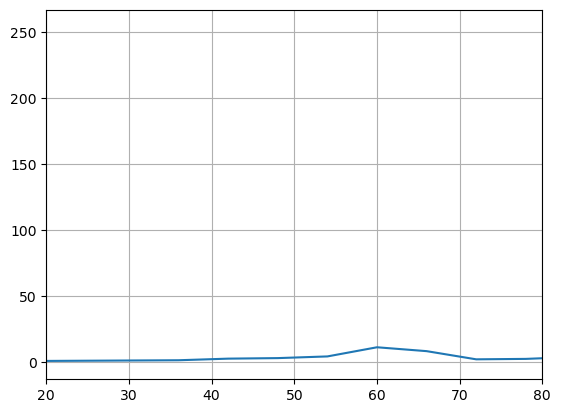

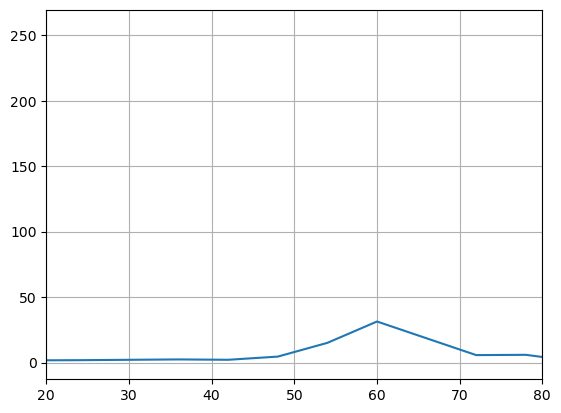

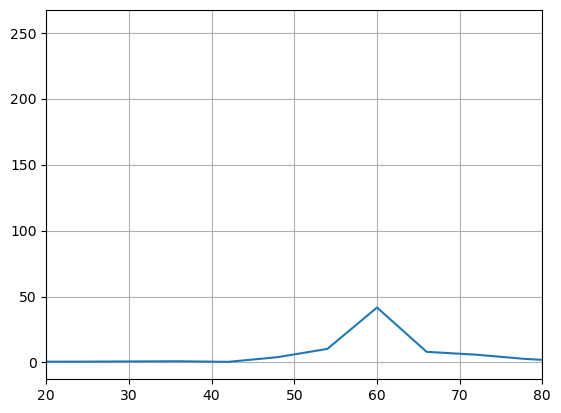

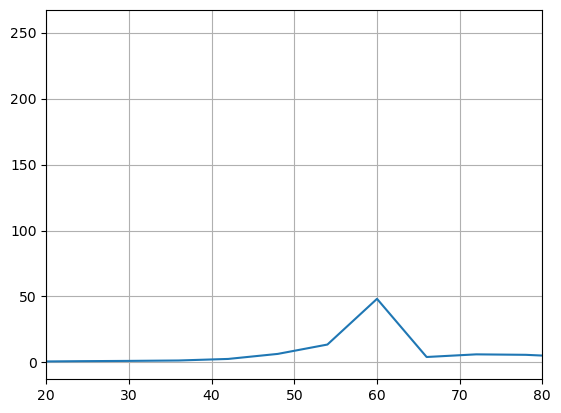

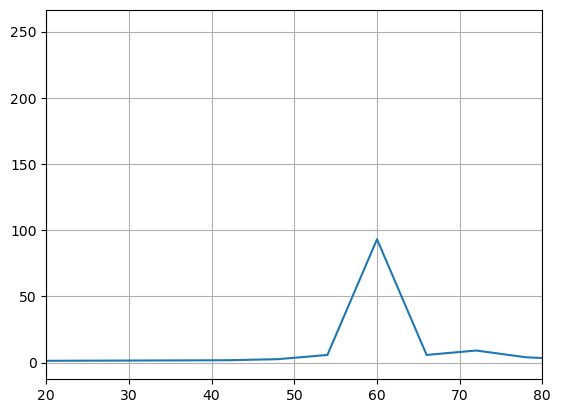

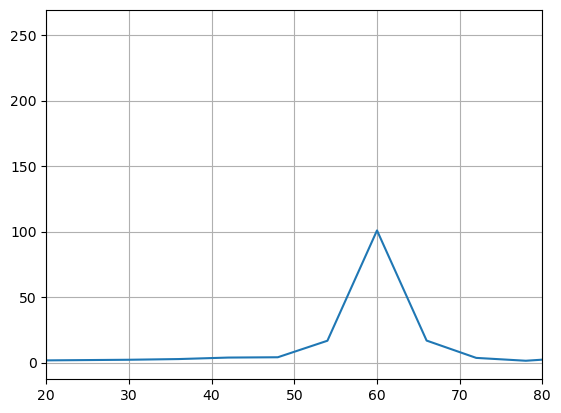

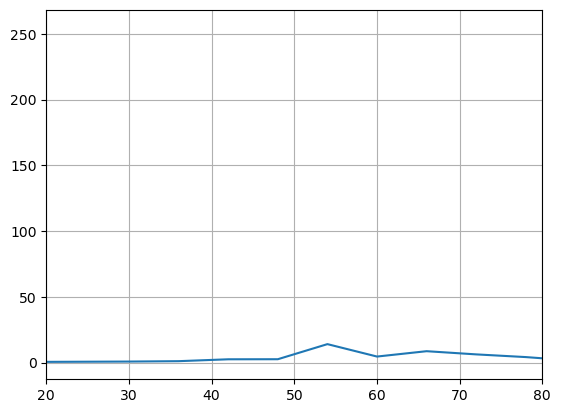

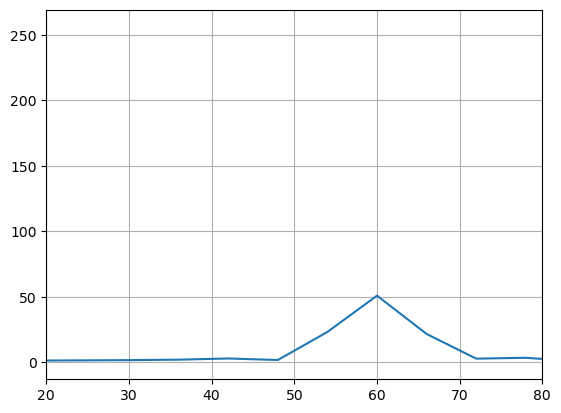

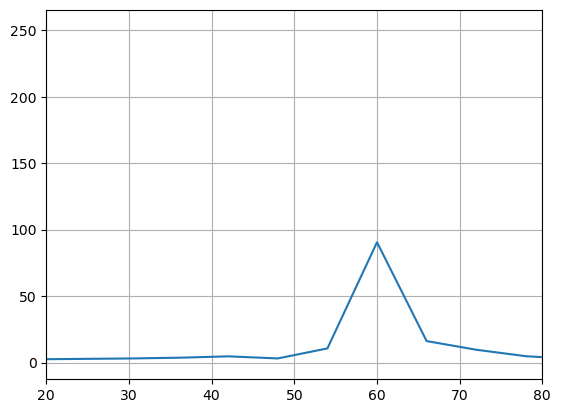

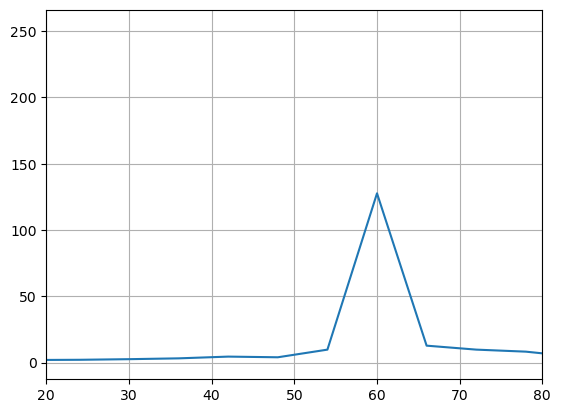

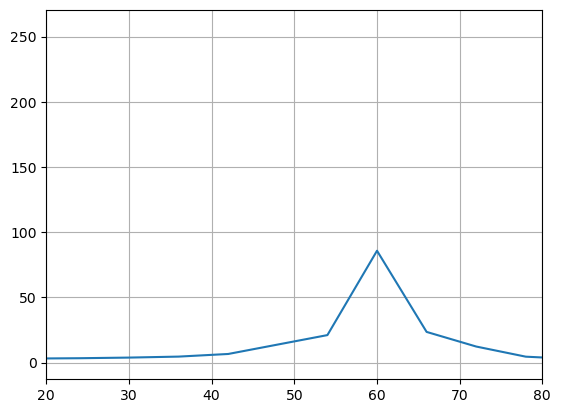

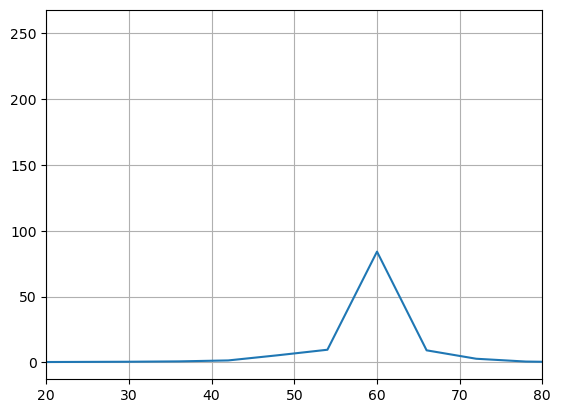

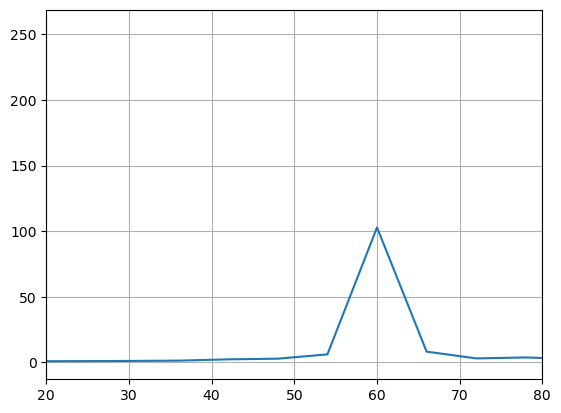

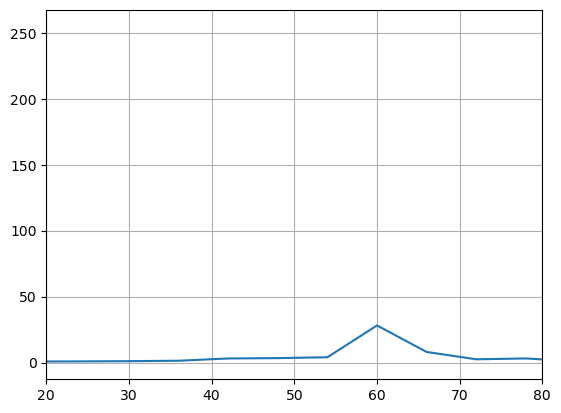

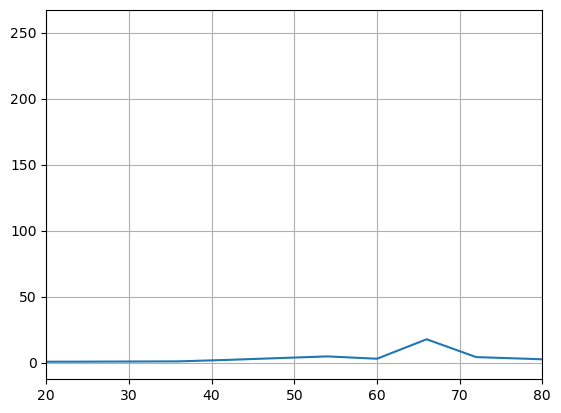

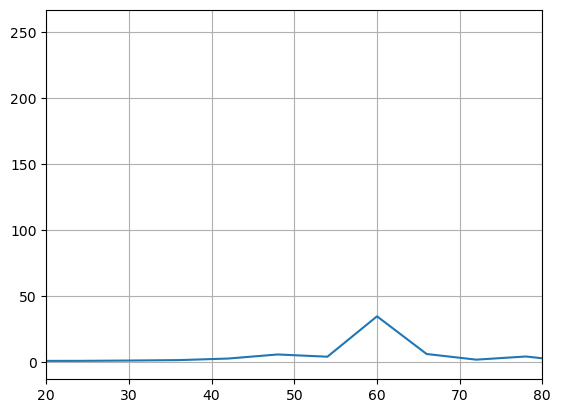

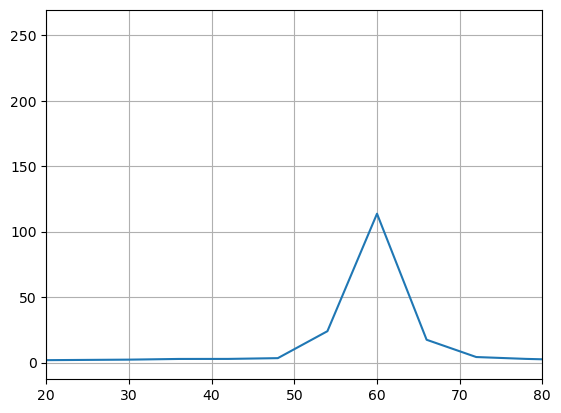

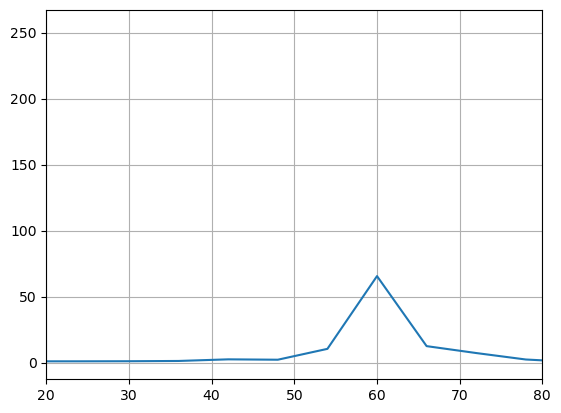

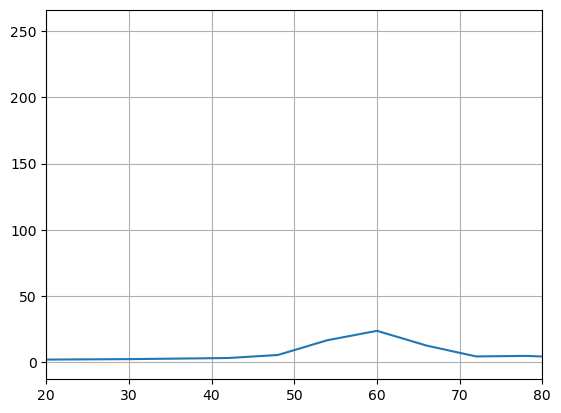

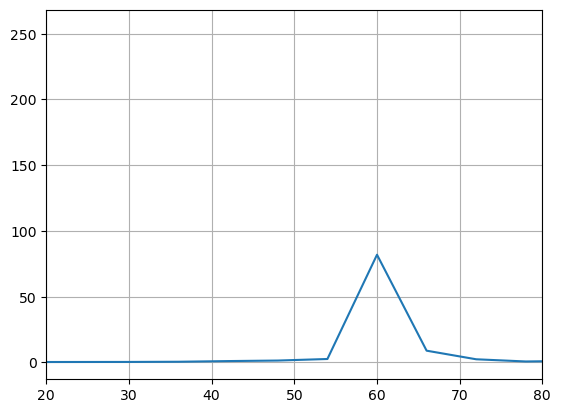

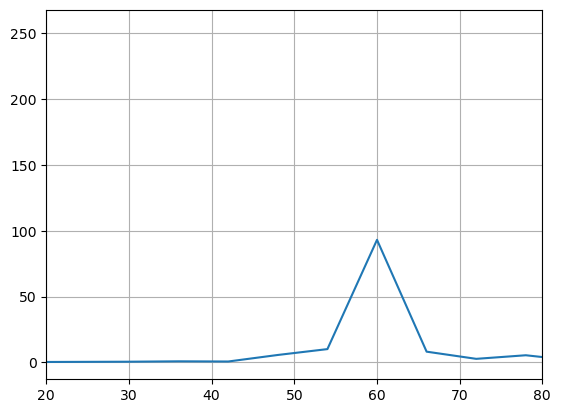

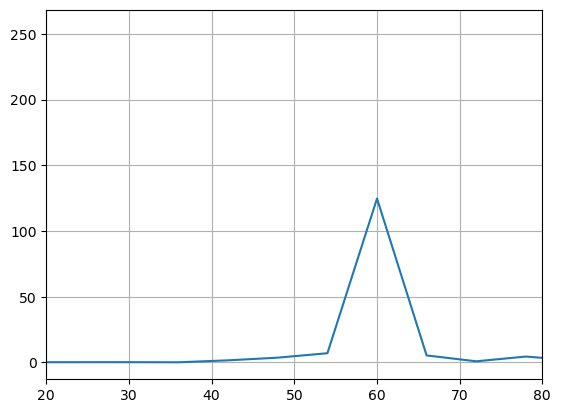

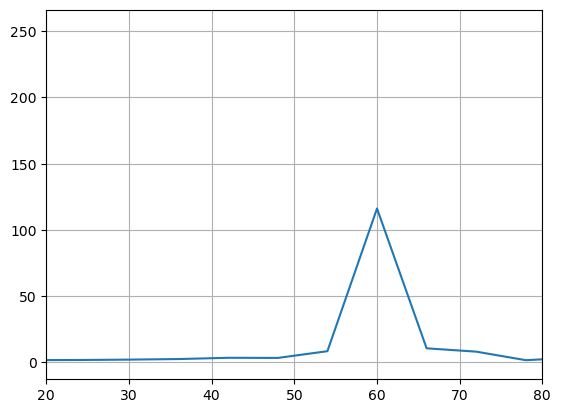

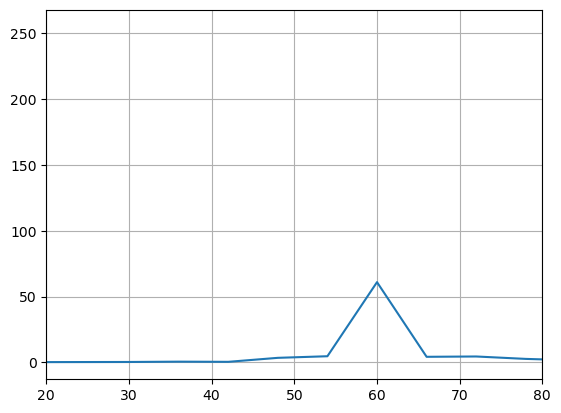

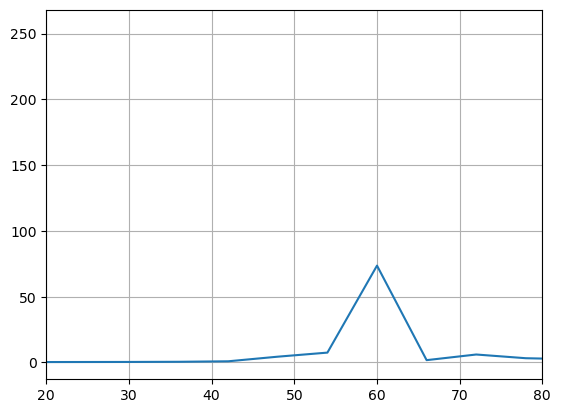

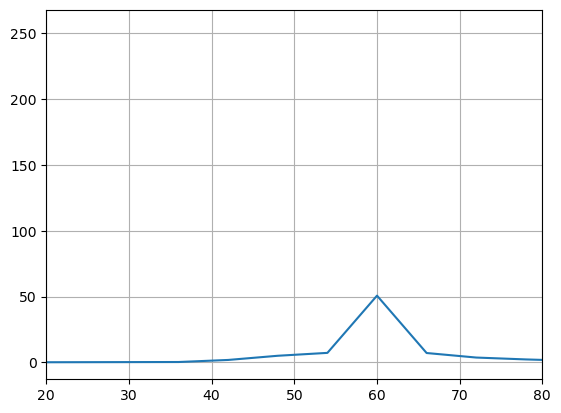

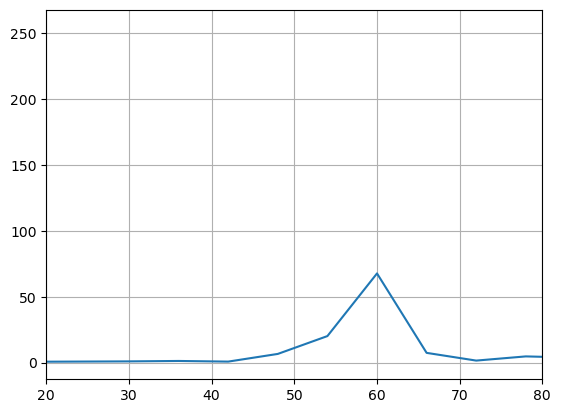

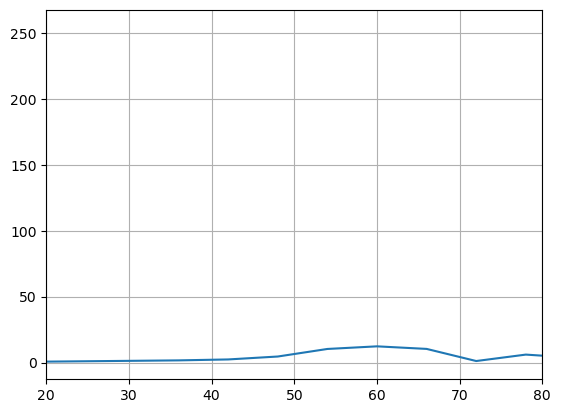

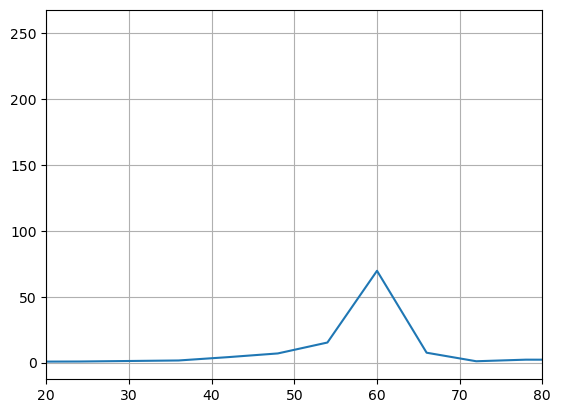

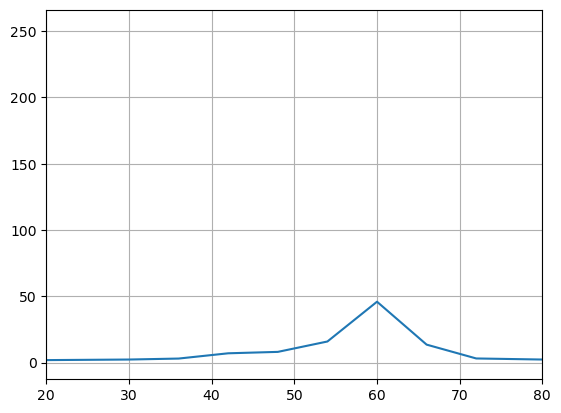

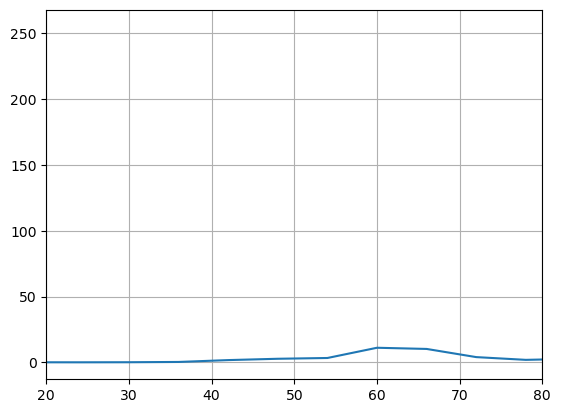

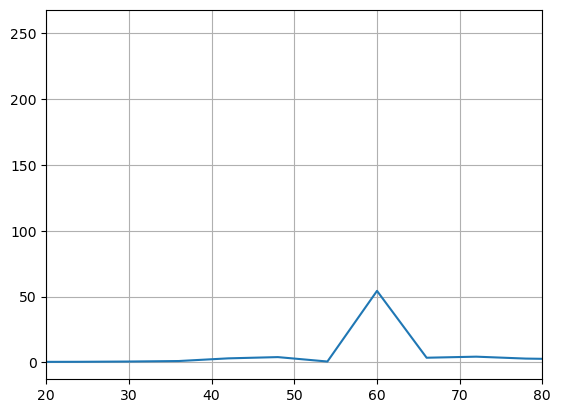

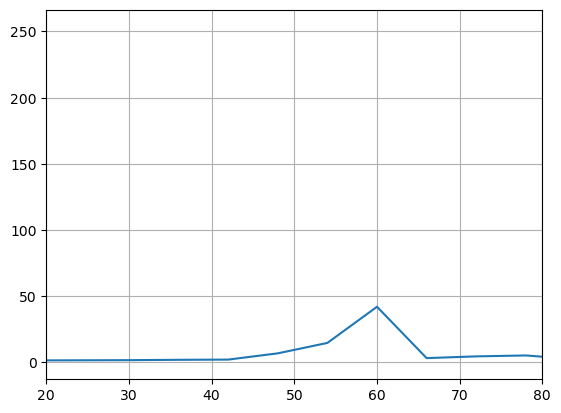

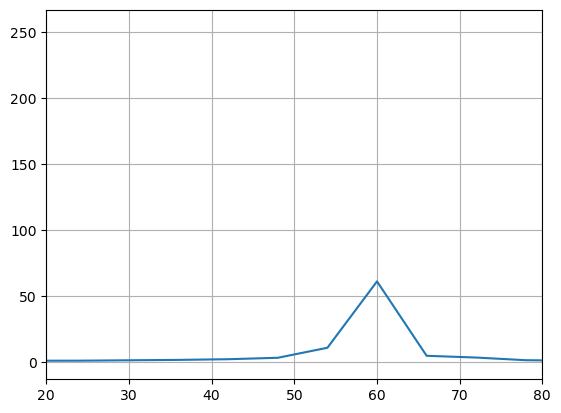

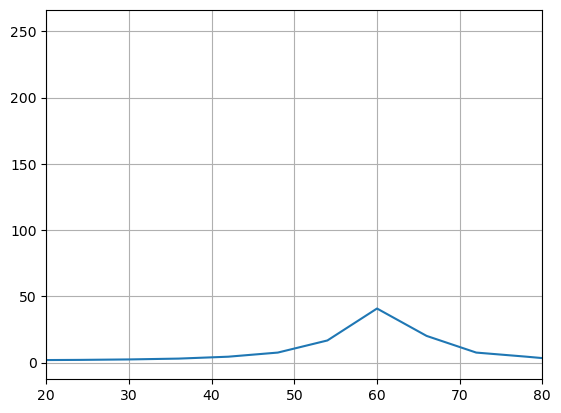

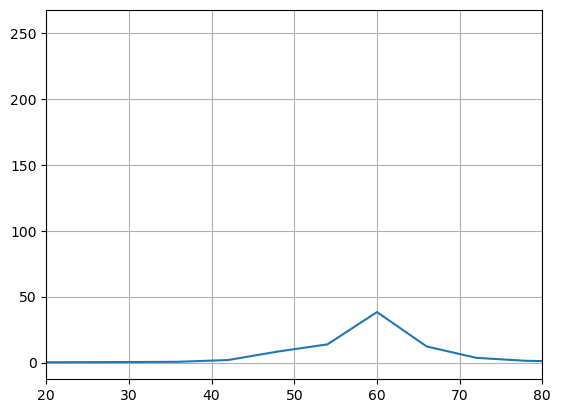

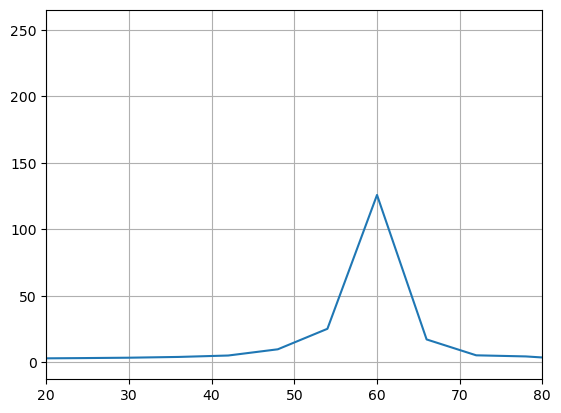

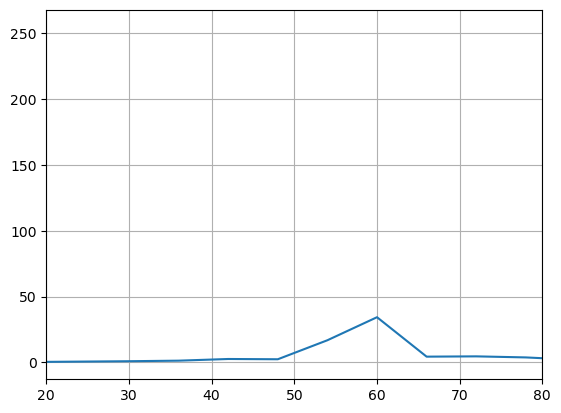

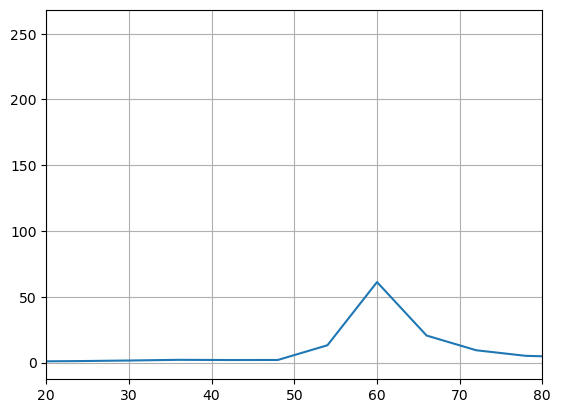

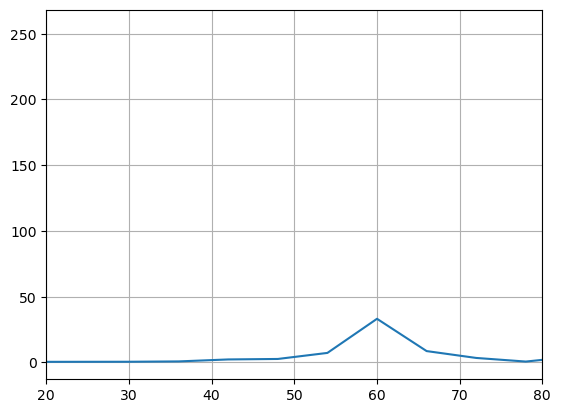

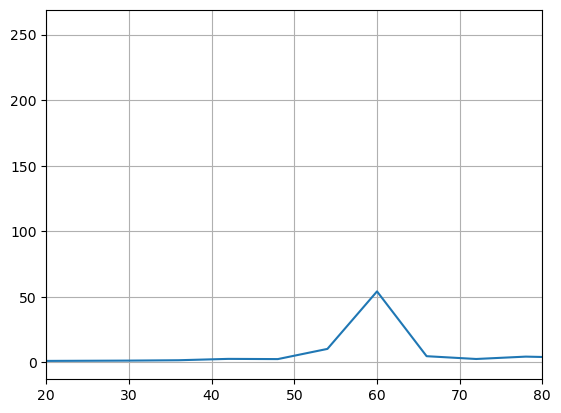

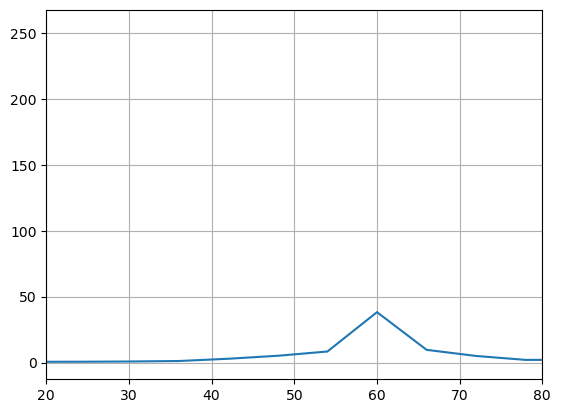

In [89]:
from scipy.fft import fft, fftfreq

for i in range(100,200):
    N = len(y_pred[sr.valid_samples_, 0, 0])
    T = 1.0 / sfreq
    yf = fft(y_pred[sr.valid_samples_, i, 0])
    xf = fftfreq(N, T)[:N//2]
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.grid()
    plt.xlim(20,80)
    plt.show()

ValueError: x and y must have same first dimension, but have shapes (2400,) and (0,)

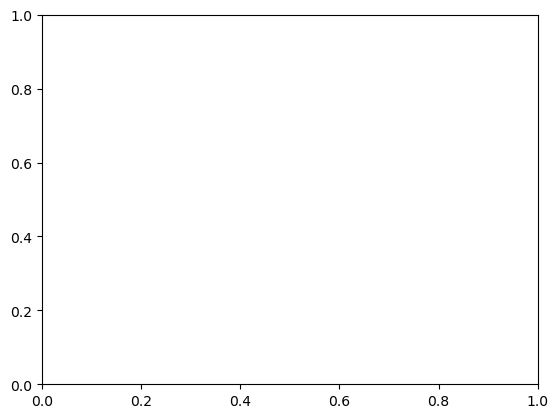

In [87]:
plt.plot(time, y_pred[sr.valid_samples_, 0, 0][: int(5 * sfreq)], color="r", lw=2)
plt.plot(time, y_pred[sr.valid_samples_, 6][: int(5 * sfreq)], color="b", lw=2)


NameError: name 'cued_noise' is not defined

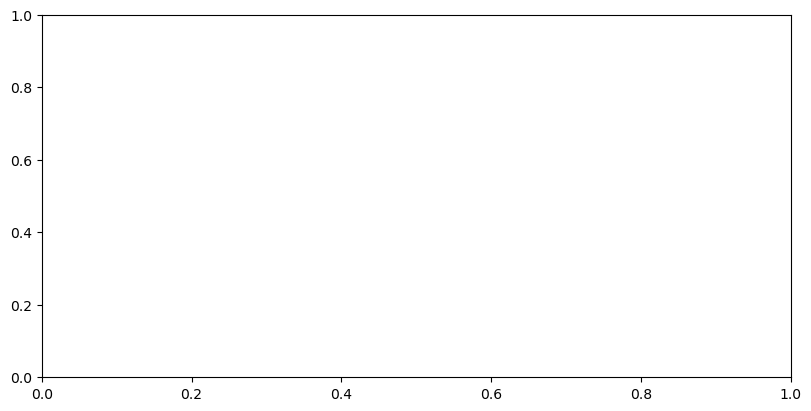

In [88]:
y_pred = sr.predict(eeg_arr[test])
time = np.linspace(0, 2.0, 5 * int(sfreq))
fig, ax = plt.subplots(figsize=(8, 4), layout="constrained")
ax.plot(
    time[::10], cued_noise[test][sr.valid_samples_, 0,0][: int(5 * sfreq)], color="grey", lw=2, ls="--"
)
ax.plot(
    time[::10], cued_noise[test][sr.valid_samples_, 5,0][: int(5 * sfreq)], color="grey", lw=2, ls="--"
)
ax.plot(time[::10], y_pred[sr.valid_samples_, 0, 0][: int(5 * sfreq)], color="r", lw=2)
# ax.legend([lns[0], ln1[0]], ["Envelope", "Reconstruction"], frameon=False)
ax.set(title="Stimulus reconstruction")
ax.set_xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

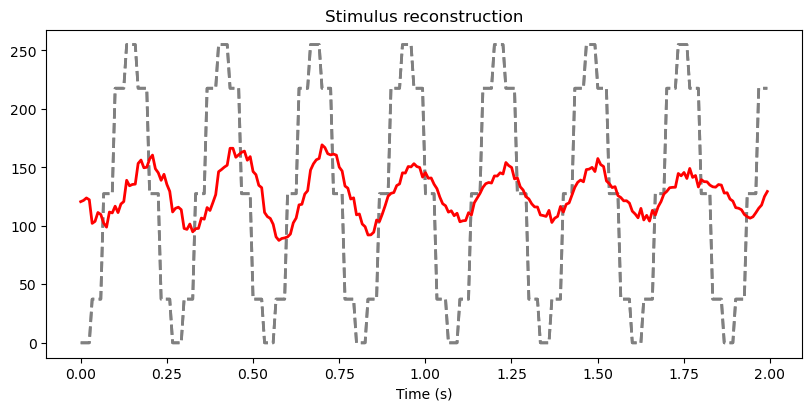

In [54]:
y_pred = sr.predict(eeg_arr[test])
time = np.linspace(0, 2.0, 5 * int(sfreq))
fig, ax = plt.subplots(figsize=(8, 4), layout="constrained")
ax.plot(
    time[::10], cued_noise[test][sr.valid_samples_, 0,0][: int(5 * sfreq)], color="grey", lw=2, ls="--"
)
ax.plot(
    time[::10], cued_noise[test][sr.valid_samples_, 4,0][: int(5 * sfreq)], color="grey", lw=2, ls="--"
)
ax.plot(time[::10], y_pred[sr.valid_samples_, 0, 0][: int(5 * sfreq)], color="r", lw=2)
# ax.legend([lns[0], ln1[0]], ["Envelope", "Reconstruction"], frameon=False)
ax.set(title="Stimulus reconstruction")
ax.set_xlabel("Time (s)")

# 2. Noise tagging condition
## 2.1 Receptive field

In [7]:
f = sio.loadmat(f'{data_path}{data_file}')
noise_stims = f['data']['noise_stims'][0][0] # block x trial x sequences (L or R tag) x timepoints
# Filter out practice trials
noise_stims = noise_stims[1:,:,:,:]

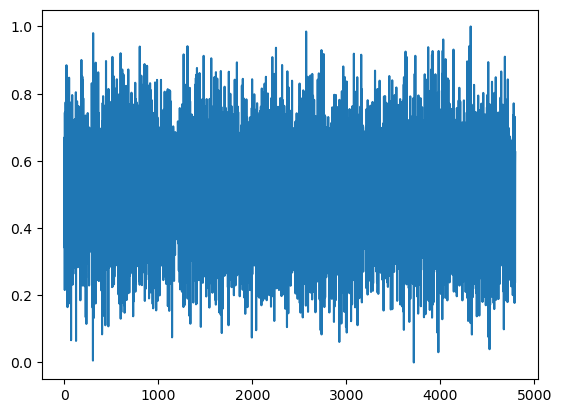

In [8]:
# First noise tag at block 15 trial 32
plt.plot(noise_stims[14,31,0,:].T)
# NB : tag 1 was always displayed on the left and tag 2 on the right

In [9]:
# Collapse to trial indexes
original_shape = noise_stims.shape
new_shape = (original_shape[0] * original_shape[1],) + original_shape[2:]
noise_stims_tr = np.reshape(noise_stims, new_shape)
noise_stims_tr = {'trial_number':np.arange(noise_stims_tr.shape[0])+1, 'data':noise_stims_tr}

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_69808/1728325881.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  else : eeg = epochs.copy().pick_channels(electrodes)


Setting up high-pass filter at 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 50.00
- Lower transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 43.75 Hz)
- Filter length: 127 samples (0.265 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
/tmp/ipykernel_69808/1728325881.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  eeg_arr = eeg[f'cued_side == {display_side_cued_tag}'].get_data()


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_69808/1728325881.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  else : eeg = epochs.copy().pick_channels(electrodes)


Setting up high-pass filter at 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 50.00
- Lower transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 43.75 Hz)
- Filter length: 127 samples (0.265 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
/tmp/ipykernel_69808/1728325881.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  eeg_arr = eeg[f'cued_side == {display_side_cued_tag}'].get_data()


Text(0, 0.5, 'Cor EEG/tag')

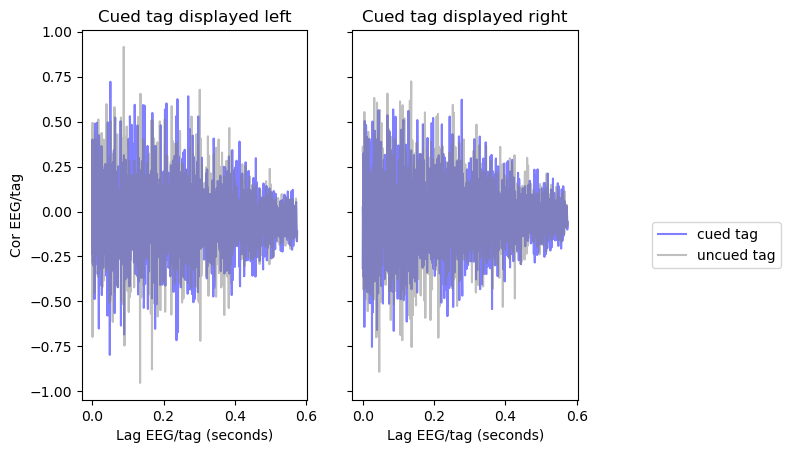

In [11]:
epochs_noistag = epochs['tagging_type==1'].copy()

# Get cross-correlation 
def cross_cor_nois(epochs, noise_tags, display_side_cued_tag, sampling_freq, electrodes=None):
    '''
    noise_tags : array trial*tag*timepoint
    display_side_cued_tag : 'left' or 'right'
    sampling_freq : 1920 or 480(Hz)
    
    Returns 2 matrices (trial*electrode*lag (in time steps between EEG start and tag start) of corr values. 
    The first matrice contains the EEG/cued_tag corr, the second the EEG/tag2 corr
    '''
    display_side_cued_tag = 0 if display_side_cued_tag == 'left' else \
        (1 if display_side_cued_tag == 'right' else ValueError("Invalid value for display_side_cued_tag"))

    # Select elec
    if electrodes is None : 
        eeg = epochs.copy()
    else : eeg = epochs.copy().pick_channels(electrodes)

    # Converge EEG and tag sampling frequencies 
    if sampling_freq == 1920:
            eeg.resample(sfreq = sampling_freq)
            # Upsample tag from 480 to 1920Hz (by repetition rather than inference)
            noise_tags = np.repeat(noise_tags, 4, axis=2)
    elif sampling_freq == 480:
        eeg.resample(sfreq = sampling_freq)
    else : raise ValueError('Sampling frequency must be 1920 or 480Hz')
    
    
    # High-pass (50Hz) EEG data + crop the before cue part
    eeg.filter(l_freq=50, h_freq = None).crop(tmin = 0)
    
    selection = eeg[f'cued_side == {display_side_cued_tag}'].selection
    eeg_arr = eeg[f'cued_side == {display_side_cued_tag}'].get_data()
    
    # Select the tags on the same trials as the EEG and only the part that was displayed during the epoch
    noise_tags = noise_stims_tr['data'][np.isin(noise_stims_tr['trial_number'], selection),:eeg_arr.shape[-1]] 

    # Loop over trials and electrodes to fill correlation matrices
    cross_corr_tag1 = np.zeros(eeg_arr.shape)
    cross_corr_tag2 = np.zeros(eeg_arr.shape)
    
    for trial in range(eeg_arr.shape[0]):
        for elec in range(eeg_arr.shape[1]):
            # Standardize eeg trial data
            trial_data = (eeg_arr[trial,elec,:]-eeg_arr[trial,elec,:].mean())/eeg_arr[trial,elec,:].std()
            # Assume the tag can only appear in the EEG when its screen display has started (crop the first tag_length-1 outputs)
            cross_corr_tag1[trial, elec] = scipy.signal.correlate(trial_data, noise_tags[trial,display_side_cued_tag,:], \
                                                        mode='full')[len(noise_tags[trial,display_side_cued_tag,:])- 1:]
            cross_corr_tag2[trial, elec] = scipy.signal.correlate(trial_data, noise_tags[trial, 1-display_side_cued_tag,:],\
                                                        mode='full')[len(noise_tags[trial,1-display_side_cued_tag,:])- 1:]

    return cross_corr_tag1, cross_corr_tag2, selection


cor_with_cued_for_cuedR, cor_with_uncued_for_cuedR, idx_cuedR = cross_cor_nois(epochs = epochs_noistag, noise_tags = noise_stims_tr, \
                                                            display_side_cued_tag = 'right', electrodes = electrodes_kabir, sampling_freq = 480)
cor_with_cued_for_cuedL, cor_with_uncued_for_cuedL, idx_cuedL = cross_cor_nois(epochs_noistag, noise_stims_tr, 'left', electrodes = electrodes_kabir, sampling_freq = 480)


# Plot
x_vals = np.arange(cor_with_cued_for_cuedR.shape[-1])*(1/1920)
fig, ax = plt.subplots(1,2, sharey=True, sharex=True)

ax[0].plot(x_vals, cor_with_cued_for_cuedL.mean(axis=(0,1)).T, color='blue', alpha=.5)
ax[0].plot(x_vals, cor_with_uncued_for_cuedL.mean(axis=(0,1)).T, color='grey', alpha=.5)

ax[1].plot(x_vals, cor_with_cued_for_cuedR.mean(axis=(0,1)).T, color='blue', label='cued tag', alpha=.5)
ax[1].plot(x_vals, cor_with_uncued_for_cuedR.mean(axis=(0,1)).T, color='grey', label='uncued tag', alpha=.5)


ax[0].set_title('Cued tag displayed left');
ax[1].set_title('Cued tag displayed right');

ax[1].legend(bbox_to_anchor = (1.3,0.5))
ax[0].set_xlabel('Lag EEG/tag (seconds)')
ax[1].set_xlabel('Lag EEG/tag (seconds)')
ax[0].set_ylabel('Cor EEG/tag')


In [212]:
idx_cuedR

array([  3,   4,   8,  13,  18,  19,  20,  24,  25,  30,  40,  49,  50,
        53,  57,  61,  62,  65,  66,  73,  80,  81,  85,  87,  95,  96,
        98,  99, 106, 119, 125, 127, 130, 131, 137, 140, 152, 155, 157,
       163, 165, 170, 174, 176, 178, 184, 187, 188, 192, 194, 195, 203,
       207, 208, 209, 219, 228, 232, 234, 239, 246, 251, 256, 257, 262,
       268, 269, 276, 279, 281, 286, 291, 295, 297, 301, 310, 313, 318,
       321, 322, 323, 325, 326, 335, 339, 342, 344, 347, 356, 357, 359,
       365, 367, 371, 374, 385, 396, 398, 400, 402, 405, 408, 411, 418,
       419, 421, 427, 432, 433])

In [209]:
idx_cuedL

array([  2,   5,  10,  12,  23,  28,  34,  36,  37,  39,  42,  43,  45,
        52,  59,  64,  70,  72,  83,  84,  86,  89,  93,  94,  97, 100,
       103, 105, 107, 110, 115, 122, 124, 128, 134, 136, 141, 143, 149,
       164, 168, 172, 173, 180, 182, 183, 197, 198, 206, 213, 214, 216,
       220, 221, 222, 226, 229, 235, 240, 243, 249, 253, 255, 259, 261,
       267, 272, 274, 282, 283, 285, 287, 290, 294, 300, 308, 311, 312,
       316, 320, 329, 334, 337, 341, 346, 349, 351, 352, 354, 361, 369,
       377, 378, 382, 383, 389, 393, 395, 397, 399, 404, 409, 417, 420,
       426, 428, 430, 435, 437, 438])

In [217]:
np.concatenate([idx_cuedL,idx_cuedR])

array([  2,   5,  10,  12,  23,  28,  34,  36,  37,  39,  42,  43,  45,
        52,  59,  64,  70,  72,  83,  84,  86,  89,  93,  94,  97, 100,
       103, 105, 107, 110, 115, 122, 124, 128, 134, 136, 141, 143, 149,
       164, 168, 172, 173, 180, 182, 183, 197, 198, 206, 213, 214, 216,
       220, 221, 222, 226, 229, 235, 240, 243, 249, 253, 255, 259, 261,
       267, 272, 274, 282, 283, 285, 287, 290, 294, 300, 308, 311, 312,
       316, 320, 329, 334, 337, 341, 346, 349, 351, 352, 354, 361, 369,
       377, 378, 382, 383, 389, 393, 395, 397, 399, 404, 409, 417, 420,
       426, 428, 430, 435, 437, 438,   3,   4,   8,  13,  18,  19,  20,
        24,  25,  30,  40,  49,  50,  53,  57,  61,  62,  65,  66,  73,
        80,  81,  85,  87,  95,  96,  98,  99, 106, 119, 125, 127, 130,
       131, 137, 140, 152, 155, 157, 163, 165, 170, 174, 176, 178, 184,
       187, 188, 192, 194, 195, 203, 207, 208, 209, 219, 228, 232, 234,
       239, 246, 251, 256, 257, 262, 268, 269, 276, 279, 281, 28

In [219]:
np.argsort(np.concatenate([idx_cuedL,idx_cuedR]))

array([  0, 110, 111,   1, 112,   2,   3, 113, 114, 115, 116,   4, 117,
       118,   5, 119,   6,   7,   8,   9, 120,  10,  11,  12, 121, 122,
        13, 123, 124,  14, 125, 126,  15, 127, 128,  16,  17, 129, 130,
       131,  18,  19, 132,  20, 133,  21,  22,  23, 134, 135,  24, 136,
       137,  25,  26,  27, 138,  28,  29,  30, 139,  31,  32, 140, 141,
        33, 142, 143,  34,  35, 144, 145,  36,  37,  38, 146, 147, 148,
       149,  39, 150,  40, 151,  41,  42, 152, 153, 154,  43,  44,  45,
       155, 156, 157, 158, 159, 160,  46,  47, 161,  48, 162, 163, 164,
        49,  50,  51, 165,  52,  53,  54,  55, 166,  56, 167, 168,  57,
       169,  58,  59, 170,  60, 171,  61,  62, 172, 173,  63,  64, 174,
        65, 175, 176,  66,  67, 177, 178, 179,  68,  69,  70, 180,  71,
        72, 181,  73, 182, 183,  74, 184,  75, 185,  76,  77, 186,  78,
       187,  79, 188, 189, 190, 191, 192,  80,  81, 193,  82, 194,  83,
       195, 196,  84, 197,  85,  86,  87,  88, 198, 199, 200,  8

In [ ]:
np.argsort(np.concatenate([idx_cuedL,idx_cuedR]))

In [236]:
a = np.random.randint(0, 5, size=(3,2,2))
b =np.random.randint(0, 3, size=(3))


In [237]:
b

array([0, 2, 1])

In [238]:
a

array([[[1, 4],
        [0, 2]],

       [[2, 0],
        [2, 4]],

       [[3, 0],
        [4, 0]]])

In [240]:
b

array([0, 2, 1])

In [239]:
a[b,:,:]

array([[[1, 4],
        [0, 2]],

       [[3, 0],
        [4, 0]],

       [[2, 0],
        [2, 4]]])

In [ ]:
matrix[out, :, :]

In [170]:
sfreq = epochs_noistag.info['sfreq']
eeg_arr = epochs_noistag.get_data(copy=True)
#(make time the first dimension)
eeg_arr = np.transpose(eeg_arr, axes=(2,0,1))
n_samples, n_trials, n_channels = eeg_arr.shape
cued_noise = np.zeros((n_trials, n_samples))
i = 0
for index, row in epochs_noistag.metadata.iterrows():
    cued_noise[i] = np.where(row.cued_side == 0, noise_stims_tr[i,0],noise_stims_tr[i,1])[:n_samples]
    i += 1
# Prepare model data (make time the first dimension)
cued_noise = cued_noise.T[:,:,np.newaxis]

split 1 / 5
Fitting 219 epochs, 1 channels


  0%|          | Sample : 0/438 [00:00<?,       ?it/s]

split 2 / 5
Fitting 219 epochs, 1 channels


  0%|          | Sample : 0/438 [00:00<?,       ?it/s]

split 3 / 5
Fitting 219 epochs, 1 channels


  0%|          | Sample : 0/438 [00:00<?,       ?it/s]

split 4 / 5
Fitting 219 epochs, 1 channels


  0%|          | Sample : 0/438 [00:00<?,       ?it/s]

split 5 / 5
Fitting 219 epochs, 1 channels


  0%|          | Sample : 0/438 [00:00<?,       ?it/s]

[Text(0.5, 1.0, 'Mean prediction score'),
 Text(0.5, 0, 'Channel'),
 Text(0, 0.5, 'Score ($r$)')]

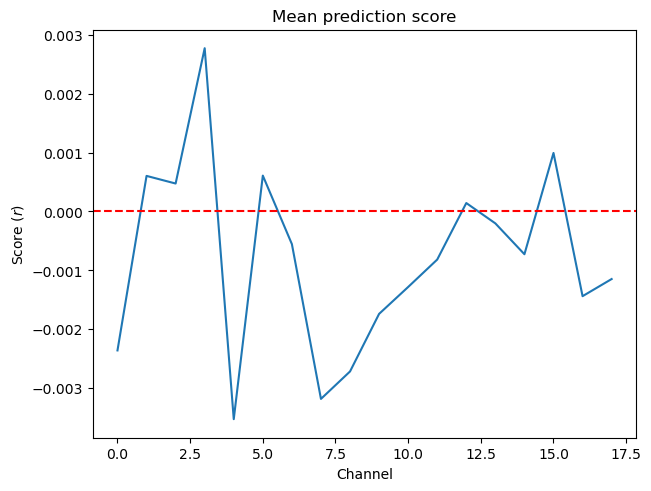

In [171]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import scale
from mne.decoding import ReceptiveField

tmin, tmax = -0.2, 0.4
# Initialize the model
rf = ReceptiveField(
    tmin, tmax, sfreq, estimator=1.0, scoring="corrcoef"
)
# We'll have (tmax - tmin) * sfreq delays
# and an extra 2 delays since we are inclusive on the beginning / end index
n_delays = int((tmax - tmin) * sfreq) + 2

n_splits = 5
cv = KFold(n_splits)


# Iterate through splits, fit the model, and predict/test on held-out data
coefs = np.zeros((n_splits, n_channels, n_delays-1))
scores = np.zeros((n_splits, n_channels))
for ii, (train, test) in enumerate(cv.split(cued_noise)):
    print(f"split {ii + 1} / {n_splits}")
    rf.fit(cued_noise[train], eeg_arr[train])
    scores[ii] = rf.score(cued_noise[test], eeg_arr[test])
    # coef_ is shape (n_outputs, n_features, n_delays). we only have 1 feature
    coefs[ii] = rf.coef_[:, 0, :]
times = rf.delays_ / float(rf.sfreq)

# Average scores and coefficients across CV splits
mean_coefs = coefs.mean(axis=0)
mean_scores = scores.mean(axis=0)

# Plot mean prediction scores across all channels
fig, ax = plt.subplots(layout="constrained")
ix_chs = np.arange(n_channels)
ax.plot(ix_chs, mean_scores)
ax.axhline(0, ls="--", color="r")
ax.set(title="Mean prediction score", xlabel="Channel", ylabel="Score ($r$)")


[Text(0.5, 1.0, 'Topomap of model coefficients\nfor delay 0.18')]

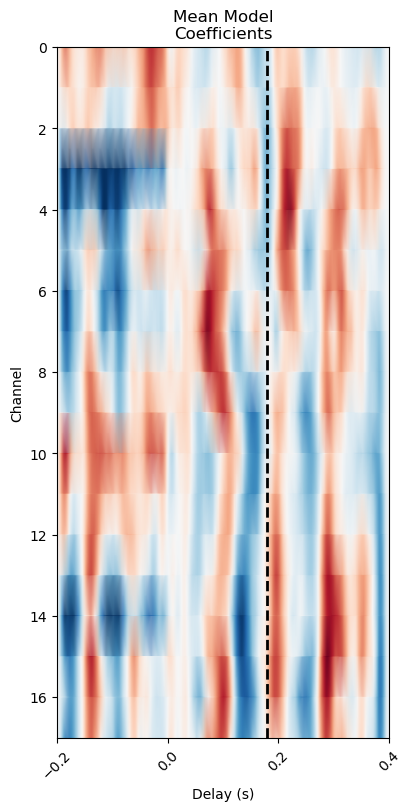

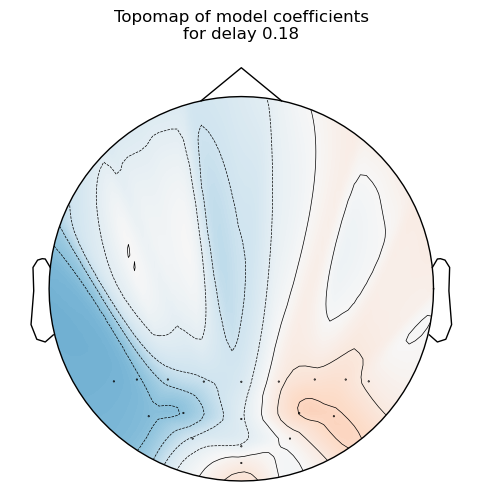

In [172]:
# Print mean coefficients across all time delays / channels (see Fig 1)
time_plot = 0.180  # For highlighting a specific time.
fig, ax = plt.subplots(figsize=(4, 8), layout="constrained")
max_coef = mean_coefs.max()
ax.pcolormesh(
    times,
    ix_chs,
    mean_coefs,
    cmap="RdBu_r",
    vmin=-max_coef,
    vmax=max_coef,
    shading="gouraud",
)
ax.axvline(time_plot, ls="--", color="k", lw=2)
ax.set(
    xlabel="Delay (s)",
    ylabel="Channel",
    title="Mean Model\nCoefficients",
    xlim=times[[0, -1]],
    ylim=[len(ix_chs) - 1, 0],
    xticks=np.arange(tmin, tmax + 0.2, 0.2),
)
plt.setp(ax.get_xticklabels(), rotation=45)

# Make a topographic map of coefficients for a given delay (see Fig 2C)
ix_plot = np.argmin(np.abs(time_plot - times))
fig, ax = plt.subplots(layout="constrained")
mne.viz.plot_topomap(
    mean_coefs[:, ix_plot], pos=epochs_noistag.info, axes=ax, show=False, vlim=(-max_coef, max_coef)
)
ax.set(title="Topomap of model coefficients\nfor delay %s" % time_plot)

In [173]:
sr = ReceptiveField(
    tmin,
    tmax,
    sfreq,
    feature_names=epochs_noistag.ch_names,
    estimator=1e4,
    scoring="corrcoef",
    patterns=True,
)
# We'll have (tmax - tmin) * sfreq delays
# and an extra 2 delays since we are inclusive on the beginning / end index
n_delays = int((tmax - tmin) * sfreq) + 2

n_splits = 3
cv = KFold(n_splits)

# Iterate through splits, fit the model, and predict/test on held-out data
coefs = np.zeros((n_splits, n_channels, n_delays-1))
patterns = coefs.copy()
scores = np.zeros((n_splits,))
for ii, (train, test) in enumerate(cv.split(cued_noise)):
    print(f"split {ii + 1} / {n_splits}")
    sr.fit(eeg_arr[train], cued_noise[train])
    scores[ii] = sr.score(eeg_arr[test], cued_noise[test])[0]
    # coef_ is shape (n_outputs, n_features, n_delays). We have 128 features
    coefs[ii] = sr.coef_[0, :, :]
    patterns[ii] = sr.patterns_[0, :, :]
times = sr.delays_ / float(sr.sfreq)

# Average scores and coefficients across CV splits
mean_coefs = coefs.mean(axis=0)
mean_patterns = patterns.mean(axis=0)
mean_scores = scores.mean(axis=0)
max_coef = np.abs(mean_coefs).max()
max_patterns = np.abs(mean_patterns).max()

split 1 / 3
Fitting 219 epochs, 18 channels


  0%|          | Sample : 0/41391 [00:00<?,       ?it/s]

split 2 / 3
Fitting 219 epochs, 18 channels


  0%|          | Sample : 0/41391 [00:00<?,       ?it/s]

split 3 / 3
Fitting 219 epochs, 18 channels


  0%|          | Sample : 0/41391 [00:00<?,       ?it/s]

(0.0, 1.0)

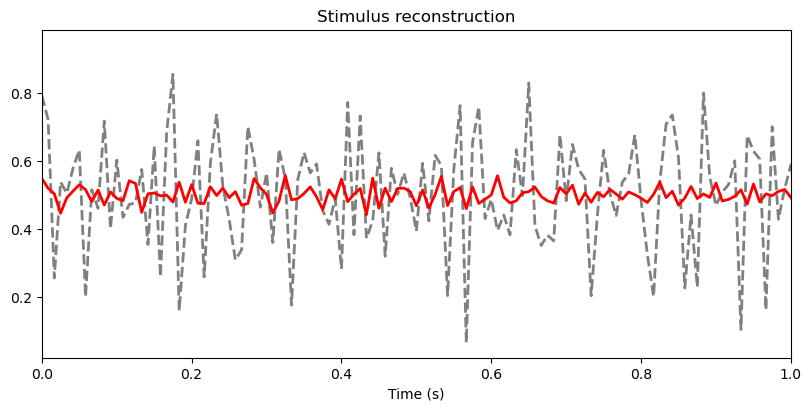

In [177]:
y_pred = sr.predict(eeg_arr[test])
time = np.linspace(0, 2.0, 5 * int(sfreq))
fig, ax = plt.subplots(figsize=(8, 4), layout="constrained")
ax.plot(
    time[::10], cued_noise[test][sr.valid_samples_, 0,0][: int(5 * sfreq)], color="grey", lw=2, ls="--"
)

ax.plot(time[::10], y_pred[sr.valid_samples_, 0, 0][: int(5 * sfreq)], color="r", lw=2)
# ax.legend([lns[0], ln1[0]], ["Envelope", "Reconstruction"], frameon=False)
ax.set(title="Stimulus reconstruction")
ax.set_xlabel("Time (s)")
ax.set_xlim(0,1)

Text(0, 0.5, 'Cor EEG/tag')

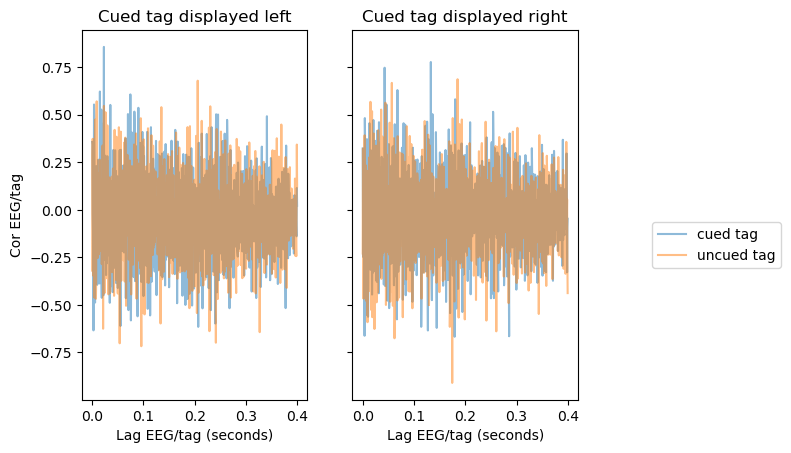

In [24]:
# Plot for lag EEG/tag up to 400ms
x_vals = np.arange(cor_with_cued_for_cuedR.shape[-1])*(1/1920)
x_vals = x_vals[:768]
fig, ax = plt.subplots(1,2, sharey=True, sharex=True)

ax[0].plot(x_vals, cor_with_cued_for_cuedL[:,:,:768].mean(axis=(0,1)).T, alpha=.5)
ax[0].plot(x_vals, cor_with_uncued_for_cuedL[:,:,:768].mean(axis=(0,1)).T, alpha=.5)

ax[1].plot(x_vals, cor_with_cued_for_cuedR[:,:,:768].mean(axis=(0,1)).T, label='cued tag', alpha=.5)
ax[1].plot(x_vals, cor_with_uncued_for_cuedR[:,:,:768].mean(axis=(0,1)).T, label='uncued tag', alpha=.5)


ax[0].set_title('Cued tag displayed left');
ax[1].set_title('Cued tag displayed right');

ax[1].legend(bbox_to_anchor = (1.3,0.5))
ax[0].set_xlabel('Lag EEG/tag (seconds)')
ax[1].set_xlabel('Lag EEG/tag (seconds)')
ax[0].set_ylabel('Cor EEG/tag')

In [25]:
print(generate_freq_tag(60).min()) #????? pas les mm range freq vs noise -> par meme range de cor
print(generate_freq_tag(60).max())
print(generate_freq_tag(60).mean())

0.0
255.0
127.5


## 2.2 Prediction

In [26]:
# Average the correlation over electrodes
uncued_R = np.mean(cor_with_uncued_for_cuedL, axis=1)
cued_R = np.mean(cor_with_cued_for_cuedR, axis=1)
uncued_L = np.mean(cor_with_uncued_for_cuedR, axis=1)
cued_L = np.mean(cor_with_cued_for_cuedL, axis=1)

# Get the correlation difference between left and right tag 
# (not cued - uncued since goal is to apply when we don't know where attention was)
diffLR_cueR = uncued_L - cued_R
diffLR_cueL = cued_L - uncued_R

# Keep only the first timepoints to reduce dimensionality
samplping_freq = 480
diffLR_cueR = diffLR_cueR[:,:int(0.5*samplping_freq)]
diffLR_cueL = diffLR_cueL[:,:int(0.5*samplping_freq)]

# Build data frame for classification
df_cor_nois = pd.DataFrame({f'diff_LR_timepoint_{i+1}': [] for i in range(diffLR_cueR.shape[1])})

for trial in range(diffLR_cueR.shape[0]):
    df_cor_nois.loc[trial, :] = diffLR_cueR[trial,:]

for trial in range(diffLR_cueL.shape[0]):
    trial_df = trial + diffLR_cueR.shape[0] 
    df_cor_nois.loc[trial_df, :] = diffLR_cueL[trial,:]

df_cor_nois['cue_side'] = np.repeat([1, 0], [diffLR_cueR.shape[0], diffLR_cueL.shape[0]])


In [51]:
import sklearn.model_selection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

# Train-test split
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(df_cor_nois.iloc[:,:-1],df_cor_nois.iloc[:,-1], test_size=0.2, random_state=0)


# Define the LDA model, parameter grid and evaluation metrics
lda = LinearDiscriminantAnalysis()

param_grid = [
  {'solver': ['lsqr', 'eigen'],'shrinkage': [0.01, 0.1, 0.2, 0.5, 0.7, 1.0]},
  {'solver': ['svd']},]

scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}

# Set up GridSearchCV with 5 fold CV
grid_search = GridSearchCV(estimator=lda, param_grid=param_grid, cv=5, scoring= scoring, refit="AUC", return_train_score=True,)

# Fit the model
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LinearDiscriminantAnalysis(),
             param_grid=[{'shrinkage': [0.01, 0.1, 0.2, 0.5, 0.7, 1.0],
                          'solver': ['lsqr', 'eigen']},
                         {'solver': ['svd']}],
             refit='AUC', return_train_score=True,
             scoring={'AUC': 'roc_auc',
                      'Accuracy': make_scorer(accuracy_score, response_method='predict')})

In [54]:
results = grid_search.cv_results_
# Evaluate the best model
best_lda = grid_search.best_estimator_

# Predict on the test set
y_pred = best_lda.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Best parameters found: {grid_search.best_params_}')
print(f'Best cross-validation accuracy: {grid_search.best_score_:.4f}')
print(f'Test set accuracy: {accuracy:.4f}')

Best parameters found: {'shrinkage': 0.2, 'solver': 'lsqr'}
Best cross-validation accuracy: 0.5869
Test set accuracy: 0.5455


# CNN

In [56]:
from tensorflow import keras

ModuleNotFoundError: No module named 'tensorflow'

In [27]:
diffLR_cueL[:,:int(0.5*480)].shape

(110, 240)

In [28]:
print(uncued_R.shape)
print(cued_R.shape)
print(uncued_L.shape)
print(cued_L.shape)

(110, 1104)
(109, 1104)
(109, 1104)
(110, 1104)


In [29]:
df_cor_nois


,diff_LR_timepoint_1,diff_LR_timepoint_2,diff_LR_timepoint_3,diff_LR_timepoint_4,diff_LR_timepoint_5,diff_LR_timepoint_6,diff_LR_timepoint_7,diff_LR_timepoint_8,diff_LR_timepoint_9,diff_LR_timepoint_10,...,diff_LR_timepoint_232,diff_LR_timepoint_233,diff_LR_timepoint_234,diff_LR_timepoint_235,diff_LR_timepoint_236,diff_LR_timepoint_237,diff_LR_timepoint_238,diff_LR_timepoint_239,diff_LR_timepoint_240,cue_side
0,0.535505,-4.800266,-5.137950,-1.032444,1.336822,7.389456,3.386303,-6.813447,-2.817192,3.896747,...,-6.922515,8.148055,8.340303,1.088649,-6.622611,3.171691,-5.148753,-1.245180,-0.781400,1
1,-2.237048,-4.742919,-3.865634,7.061287,-1.653940,-0.592840,4.009896,-5.539822,-3.976509,4.679568,...,-3.930423,1.282665,4.552018,0.119119,1.702938,-0.631567,-2.726279,-1.877523,1.459557,1
2,-5.618922,-3.946360,5.651058,1.758203,3.430646,-0.509764,-3.285503,-4.875188,1.883946,2.687458,...,-1.289203,-1.880173,4.262728,3.554583,-4.145517,-6.140142,-1.085694,5.702781,1.883410,1
3,3.502021,5.756303,-1.605565,2.390294,-2.389306,-5.989397,0.712325,2.314645,0.734176,2.551404,...,-1.162453,-5.588493,-1.447064,3.035359,-2.810047,6.306382,1.228954,-3.260705,-0.505192,1
4,4.161524,4.590379,1.051841,-9.102804,-0.222888,2.320185,-6.279599,1.196728,3.713914,1.613613,...,-7.359148,-6.010726,0.402491,2.554106,0.949157,5.035756,1.067955,-7.238057,-0.288308,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,3.658304,6.009154,0.098406,-3.792137,1.004571,1.159419,1.893210,-4.843381,0.238301,0.117994,...,0.274388,-0.256143,-4.140049,2.671779,1.004685,-4.823947,0.553919,2.404490,7.135778,0
215,2.069500,-8.644796,-2.446547,3.597990,5.161468,0.671777,-2.556311,-3.659843,1.248023,0.195545,...,-1.261527,-1.449382,-5.590637,0.043138,3.560251,4.536658,-0.801494,-1.014523,-0.433473,0
216,2.714175,1.057668,-4.871943,-1.374290,1.566439,2.062014,-1.655250,1.797804,-0.495892,-2.342133,...,-2.425793,-0.740987,0.856361,-0.470528,0.645059,2.271556,-0.737878,0.747715,-6.553468,0
217,1.746725,1.135167,1.521382,-7.573773,-3.750317,0.827132,5.378554,3.334315,2.068553,-3.219311,...,-2.412911,-5.565731,-6.518638,1.021480,6.497959,3.925553,-2.861046,-1.310845,0.783892,0


In [1]:
X_train

NameError: name 'X_train' is not defined